Leave-one-group-out for the immune response prediction

通过TCR序列相似性和克隆转录基线约束得到克隆型的原型，超越TCR或T cell的pMHC结合预测，构建了实际免疫应答预测的方法

不同患者之间，其T细胞的抗原识别存在共性的可被机器学习模型识别的模式，如相似的motif基序和相似的基因表达所形成的细胞亚型，构建学习模型并训练已有患者的数据、识别免疫应答模式，泛化到新患者，具有极高的临床相关性优势。

In [1]:
import warnings
from anndata import ImplicitModificationWarning
warnings.filterwarnings("ignore", category=ImplicitModificationWarning)
warnings.filterwarnings("ignore")

In [2]:
import os,sys
sys.path.append(os.path.realpath(os.path.join(os.getcwd(), '..')))
import numpy as np
import scanpy as sc
import vqtcr as vq

In [3]:
path_base = '/mnt/d/Dataset/MrTCR/BCC/'
path_data = path_base + 'scc_merged_airr.h5ad'

In [4]:
vq.set_random_seed(2025)
adata = sc.read_h5ad(path_data)
adata

AnnData object with n_obs × n_vars = 14820 × 5000
    obs: 'patient', 'treatment', 'cluster', 'UMAP1', 'UMAP2', 'cdr3s_nt', 'cdr3s_aa', 'receptor_type', 'receptor_subtype', 'chain_pairing', 'clonotype', 'clonotype_size', 'VJ_1_junction_aa', 'VDJ_1_junction_aa', 'alpha_len', 'beta_len'
    var: 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'chain_indices', 'clonotype', 'cluster_colors', 'hvg', 'ir_dist_nt_identity', 'log1p', 'patient_colors', 'treatment_colors'
    obsm: 'airr', 'alpha_mask', 'alpha_seq', 'beta_mask', 'beta_seq', 'chain_indices'

In [5]:
adata.obs.cluster.value_counts()

CD8_ex        2562
CD8_mem       2509
Treg          2088
Tfh           1900
Naive         1346
CD8_naive     1227
Th17          1191
CD8_eff        747
CD8_act        707
CD8_ex_act     543
Name: cluster, dtype: int64

In [6]:
adata.obs.patient.value_counts()

su010    5355
su011    4000
su013    3126
su014    2339
Name: patient, dtype: int64

In [7]:
params = vq.get_pred_config(lr=1e-3, latent_dim=64, dropout=0.2, n_labels=10, num_subspace=2, codewords_per_space=64)
params['epoch'] = 20
params

{'dim_latent': 64,
 'batch_size': 512,
 'lr': 0.001,
 'dropout': 0.2,
 'epoch': 20,
 'early': 10,
 'dataset': '',
 'save_path': '',
 'direction': 'max',
 'weight_decay': 0.0001,
 'loss_weight': [1.0, 1.0, 1.0, 1.0],
 'gex': {'dim_latent': 64, 'act': 'elu', 'norm': True},
 'tcr': {'esm_type': 'facebook/esm2_t6_8M_UR50D',
  'kmer_kernels': [1, 3, 5, 7],
  'dim_latent': 64,
  'dim_emb': 64,
  'num_heads': 8,
  'forward_expansion': 4,
  'dropout': 0.2,
  'num_encoder': 2,
  'num_decoder': 2,
  'mask_rate': 0.15,
  'beta_only': False,
  'esm_tokens': True},
 'fus': {'dim_latent': 64, 'dropout': 0.2, 'film_reg': 1.0},
 'pty': {'dim_latent': 128,
  'num_subspace': 2,
  'codewords_per_space': 64,
  'eps': 1e-05,
  'init_scale': 1.0,
  'ema_decay': 0.99,
  'commitment_beta': 0.25,
  'use_cosine': True,
  'dead_code_interval': 1000,
  'dead_code_threshold': 0.0001,
  'dead_code_topk': 16,
  'diversity_weight': 0.001},
 'pred': {'dim_latent': 64, 'dropout': 0.2, 'n_labels': 10}}

Leave one donor out(LoDonor) TCR-pMHC binding prediction

pretrain on all donors

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


warmup codebook:   0%|          | 0/10 [00:00<?, ?it/s]

1.5180284976959229 3.5314619541168213 0.6799658536911011
1.3009837865829468 3.3447351455688477 0.6793107986450195
0.6052905917167664 3.244699478149414 0.5934807658195496
0.4467783570289612 3.121548891067505 0.526104211807251
0.3668171763420105 2.9959194660186768 0.4661492705345154
0.30817997455596924 2.853119373321533 0.40987473726272583
0.30291175842285156 2.6652092933654785 0.3571404218673706
0.24124830961227417 2.564511775970459 0.30846506357192993
0.21220237016677856 2.460885524749756 0.2636876106262207
0.20633424818515778 2.272045135498047 0.22306230664253235
0.19661732017993927 2.199028730392456 0.18761509656906128
0.1842019259929657 2.18203067779541 0.15752515196800232
0.17529544234275818 2.093836784362793 0.13212141394615173
0.1623610109090805 2.1456856727600098 0.1106991171836853
0.16386669874191284 2.091287136077881 0.09280580282211304
0.15876656770706177 2.034635305404663 0.07788968086242676
0.15555286407470703 2.0779318809509277 0.0655464306473732
0.15465986728668213 2.0843

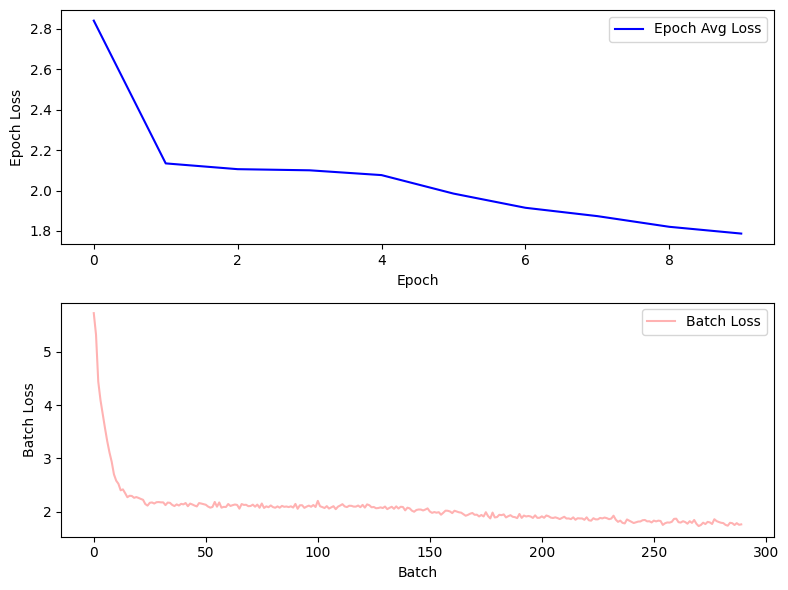

Clustering 14820 points in 64D to 64 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
  Iteration 19 (0.08 s, search 0.08 s): objective=12921.8 imbalance=1.250 nsplit=0       
Clustering 14820 points in 64D to 64 clusters, redo 1 times, 20 iterations
  Preprocessing in 0.00 s
  Iteration 19 (0.06 s, search 0.06 s): objective=11457.6 imbalance=1.098 nsplit=0       


Pre-Training:   0%|          | 0/20 [00:00<?, ?it/s]

perplexity_per_codebook [55.433753967285156, 57.619972229003906] dead_rate_per_codebook[0.0, 0.0]
0.10811293125152588 1.6442514657974243 0.0039006629958748817 0.00010309853678336367
perplexity_per_codebook [54.411685943603516, 52.36121368408203] dead_rate_per_codebook[0.0, 0.03125]
0.15367794036865234 2.810295820236206 0.0038273329846560955 0.0001252472575288266
perplexity_per_codebook [52.941890716552734, 6.525284290313721] dead_rate_per_codebook[0.03125, 0.71875]
0.15120118856430054 2.7747130393981934 0.039060331881046295 0.0007048945408314466
perplexity_per_codebook [34.473236083984375, 1.0] dead_rate_per_codebook[0.15625, 0.984375]
0.13575518131256104 2.7298293113708496 0.025779061019420624 0.00035630629281513393
perplexity_per_codebook [20.804550170898438, 1.0] dead_rate_per_codebook[0.34375, 0.984375]
0.12347723543643951 2.6763052940368652 0.014437401667237282 0.0003721886605489999
perplexity_per_codebook [11.719215393066406, 1.0] dead_rate_per_codebook[0.515625, 0.984375]
0.1327

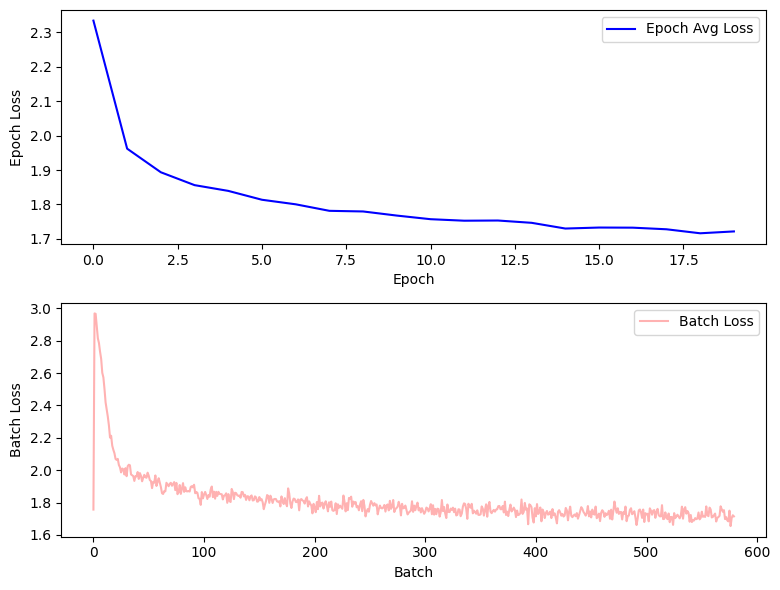

In [8]:
vqtcr = vq.vqTCR(params, adata, labels='cluster_tcell')
vqtcr.pretrain(col_name='patient', 
               set_name=['su010','su011','su013','su014'],
               sample_mode='clonotype', 
               shuffle=False,
               labels=None,
               visual=True)

In [9]:
adata = vqtcr.get_latent(adata, col_name='patient', set_name=['su010','su011','su013','su014'], gene_analys=True)

perplexity_per_codebook [34.268348693847656, 21.924589157104492] dead_rate_per_codebook[0.109375, 0.34375]
perplexity_per_codebook [34.05365753173828, 20.754074096679688] dead_rate_per_codebook[0.109375, 0.34375]
perplexity_per_codebook [31.797168731689453, 21.237838745117188] dead_rate_per_codebook[0.125, 0.25]
perplexity_per_codebook [20.229652404785156, 10.609214782714844] dead_rate_per_codebook[0.21875, 0.59375]
perplexity_per_codebook [17.910247802734375, 10.175802230834961] dead_rate_per_codebook[0.3125, 0.625]
perplexity_per_codebook [20.576356887817383, 10.483034133911133] dead_rate_per_codebook[0.203125, 0.625]
perplexity_per_codebook [39.22431182861328, 25.250978469848633] dead_rate_per_codebook[0.125, 0.34375]
perplexity_per_codebook [40.22517395019531, 24.10475730895996] dead_rate_per_codebook[0.109375, 0.265625]
perplexity_per_codebook [40.048465728759766, 23.388113021850586] dead_rate_per_codebook[0.09375, 0.296875]
perplexity_per_codebook [41.034908294677734, 24.93012428

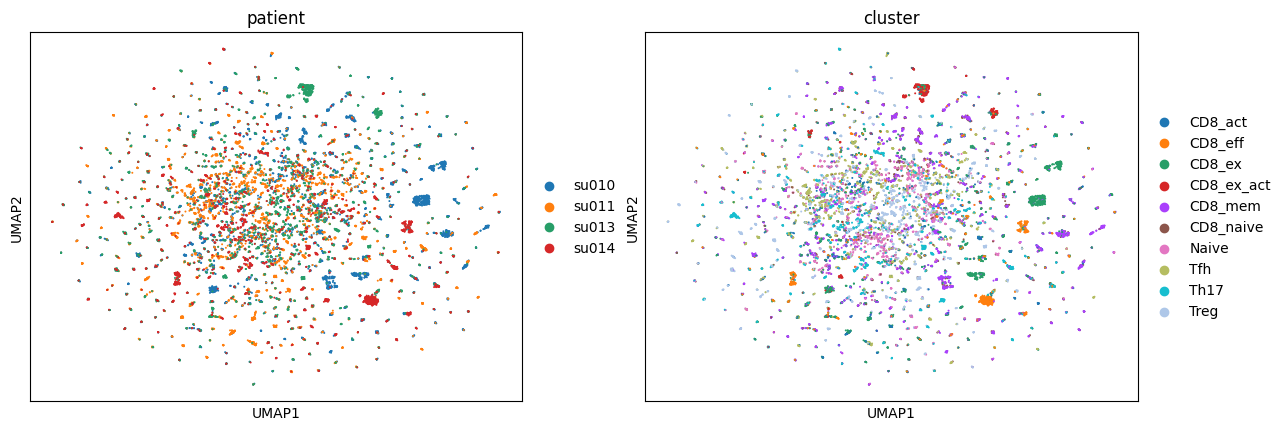

In [10]:
# tcr latent space
sc.pp.neighbors(adata, use_rep='htcell')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['patient', 'cluster'])

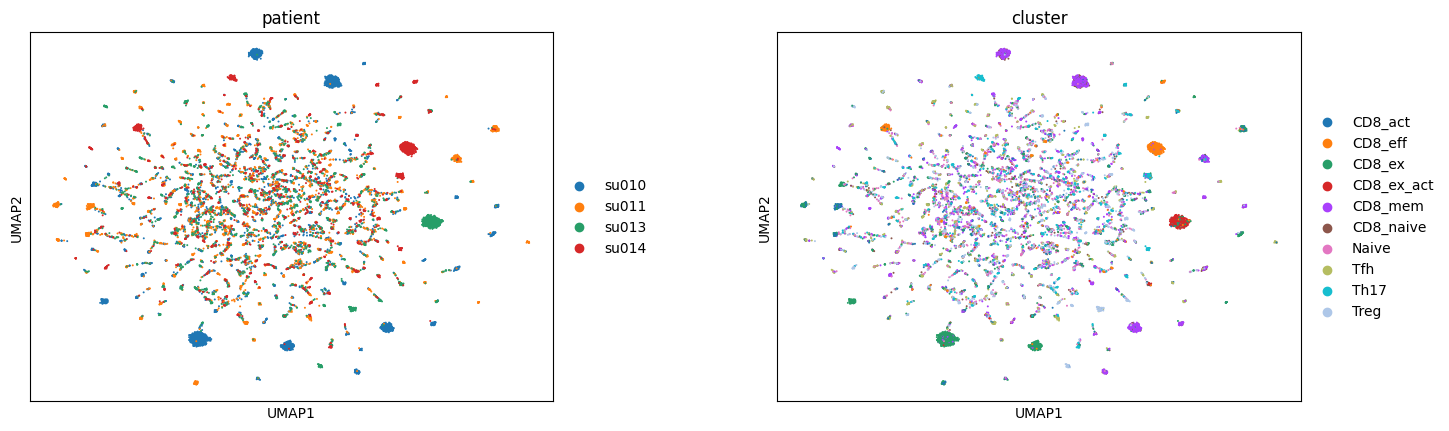

In [11]:
# tcr latent space
sc.pp.neighbors(adata, use_rep='htcr')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['patient', 'cluster'], wspace=0.3)

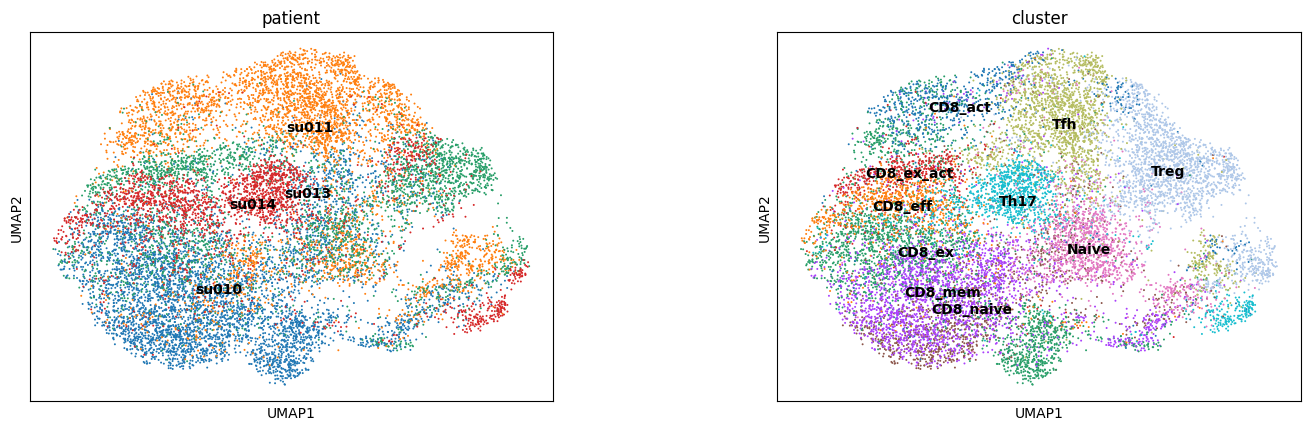

In [12]:
# gex residual latent space
sc.pp.neighbors(adata, use_rep='hgex')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['patient', 'cluster'], wspace=0.3, legend_loc='on data')

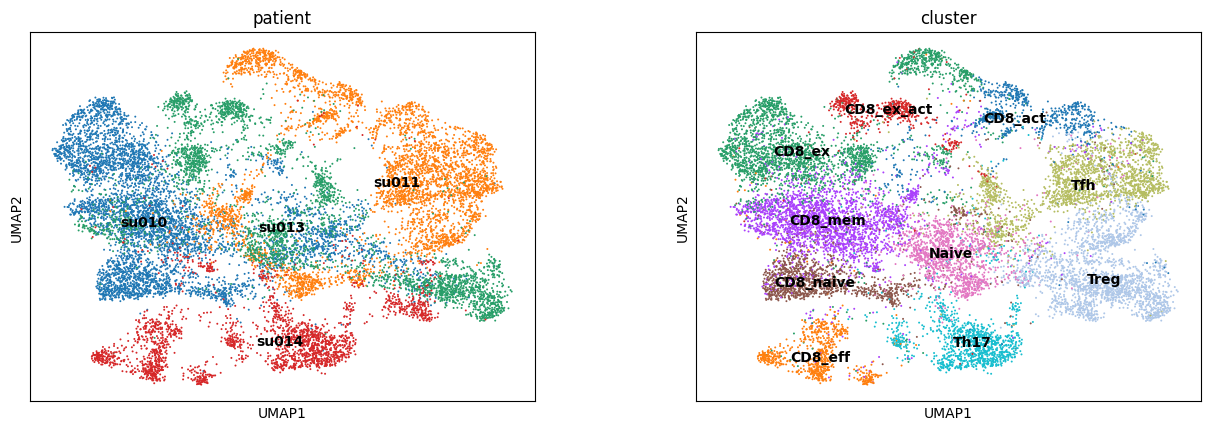

In [13]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color=['patient', 'cluster'], wspace=0.2, legend_loc='on data')

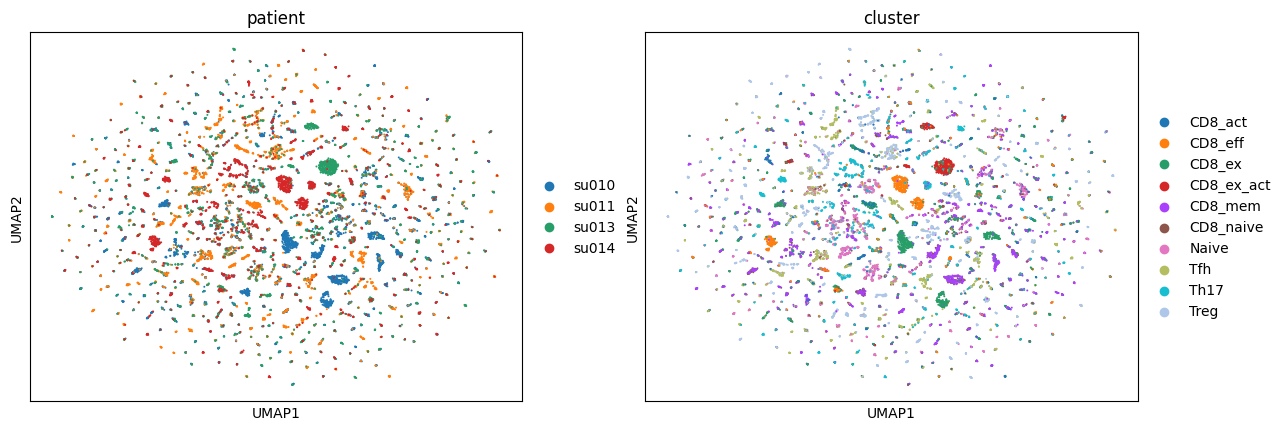

In [14]:
adata_base = adata.copy()
adata_base.X = adata.obsm['base_tcells']
sc.tl.pca(adata_base)
sc.pp.neighbors(adata_base)
sc.tl.umap(adata_base)
sc.pl.umap(adata_base, color=['patient', 'cluster'])

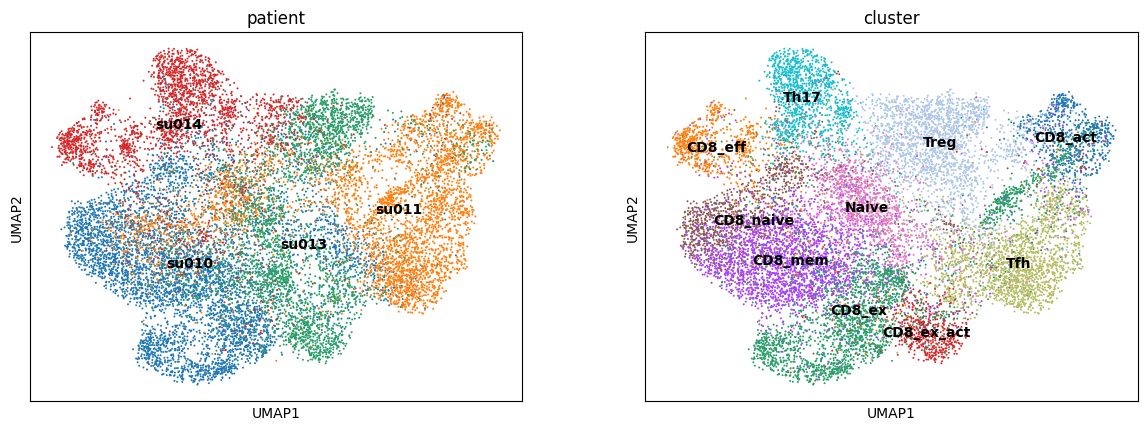

In [15]:
adata_bias = adata.copy()
adata_bias.X = adata.obsm['bias_gexs']
sc.tl.pca(adata_bias)
sc.pp.neighbors(adata_bias)
sc.tl.umap(adata_bias)
sc.pl.umap(adata_bias, color=['patient', 'cluster'], legend_loc='on data')

三元图绘制——ex\act\ex_act, 治疗前后各个病人的变化 (10/11 response)

In [16]:
adata.obs.cluster.value_counts()

CD8_ex        2562
CD8_mem       2509
Treg          2088
Tfh           1900
Naive         1346
CD8_naive     1227
Th17          1191
CD8_eff        747
CD8_act        707
CD8_ex_act     543
Name: cluster, dtype: int64

In [17]:
adata.obs.to_csv("obs.csv")

In [18]:
import pandas as pd
import numpy as np

obs = pd.read_csv("obs.csv")

# 查看一下基本信息
print(obs["cluster"].value_counts())
print(obs["treatment"].value_counts())
print(obs["patient"].value_counts())


CD8_ex        2562
CD8_mem       2509
Treg          2088
Tfh           1900
Naive         1346
CD8_naive     1227
Th17          1191
CD8_eff        747
CD8_act        707
CD8_ex_act     543
Name: cluster, dtype: int64
pre     8204
post    6616
Name: treatment, dtype: int64
su010    5355
su011    4000
su013    3126
su014    2339
Name: patient, dtype: int64


In [19]:
# 只保留 CD8 相关 cluster
cd8_mask = obs["cluster"].str.startswith("CD8_")
obs_cd8 = obs[cd8_mask].copy()

obs_cd8["cd8_state3"] = np.nan
obs_cd8.loc[obs_cd8["cluster"].isin(["CD8_mem", "CD8_naive"]), "cd8_state3"] = "CD8_mem"
obs_cd8.loc[obs_cd8["cluster"].isin(["CD8_act", "CD8_eff"]),  "cd8_state3"] = "CD8_act_eff"
obs_cd8.loc[obs_cd8["cluster"].isin(["CD8_ex", "CD8_ex_act"]), "cd8_state3"] = "CD8_ex"

obs_cd8 = obs_cd8.dropna(subset=["cd8_state3"])


In [20]:
cd4_mask = obs["cluster"].isin(["Treg", "Tfh", "Th17"])
obs_cd4 = obs[cd4_mask].copy()
obs_cd4["cd4_state3"] = obs_cd4["cluster"]  # 直接用原名字


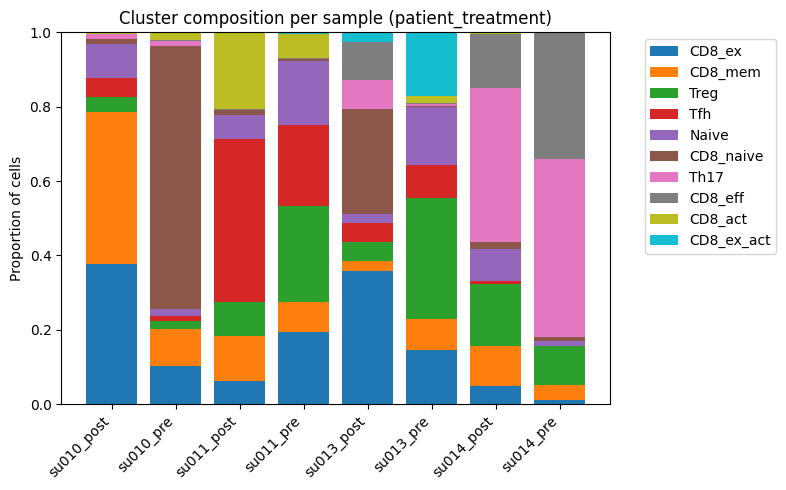

In [21]:
import matplotlib.pyplot as plt

# 统计 patient × treatment × cluster 的细胞数
comp_all = (
    obs.groupby(["patient", "treatment", "cluster"])
       .size()
       .reset_index(name="n_cells")
)

# 方便画图：每一列是一个样本( patient+treatment )
comp_all["sample"] = comp_all["patient"] + "_" + comp_all["treatment"]

pivot_all = comp_all.pivot_table(index="cluster",
                                 columns="sample",
                                 values="n_cells",
                                 fill_value=0)

# 按总量排序 cluster（可选）
cluster_order = pivot_all.sum(axis=1).sort_values(ascending=False).index
pivot_all = pivot_all.loc[cluster_order]

# 计算每个 sample 的总细胞数，用于比例（可选）
col_sums = pivot_all.sum(axis=0)
pivot_prop = pivot_all / col_sums

# 画堆叠条形图（比例）
fig, ax = plt.subplots(figsize=(8, 5))

bottom = np.zeros(len(pivot_prop.columns))
x = np.arange(len(pivot_prop.columns))

for cl in pivot_prop.index:
    values = pivot_prop.loc[cl].values
    ax.bar(x, values, bottom=bottom, label=cl)
    bottom += values

ax.set_xticks(x)
ax.set_xticklabels(pivot_prop.columns, rotation=45, ha="right")
ax.set_ylabel("Proportion of cells")
ax.set_title("Cluster composition per sample (patient_treatment)")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()


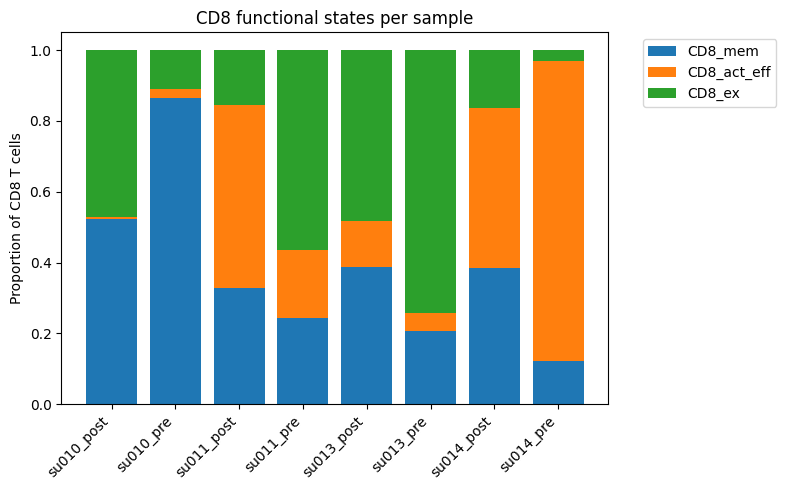

In [22]:
# 统计 patient × treatment × cd8_state3
comp_cd8 = (
    obs_cd8.groupby(["patient", "treatment", "cd8_state3"])
           .size()
           .reset_index(name="n_cells")
)

comp_cd8["sample"] = comp_cd8["patient"] + "_" + comp_cd8["treatment"]

pivot_cd8 = comp_cd8.pivot_table(index="cd8_state3",
                                 columns="sample",
                                 values="n_cells",
                                 fill_value=0)

# 计算比例
col_sums = pivot_cd8.sum(axis=0)
pivot_cd8_prop = pivot_cd8 / col_sums

# 固定顺序：记忆 -> 激活效应 -> 耗竭
cd8_order = ["CD8_mem", "CD8_act_eff", "CD8_ex"]
pivot_cd8_prop = pivot_cd8_prop.loc[cd8_order]

fig, ax = plt.subplots(figsize=(8, 5))

bottom = np.zeros(len(pivot_cd8_prop.columns))
x = np.arange(len(pivot_cd8_prop.columns))

for state in pivot_cd8_prop.index:
    values = pivot_cd8_prop.loc[state].values
    ax.bar(x, values, bottom=bottom, label=state)
    bottom += values

ax.set_xticks(x)
ax.set_xticklabels(pivot_cd8_prop.columns, rotation=45, ha="right")
ax.set_ylabel("Proportion of CD8 T cells")
ax.set_title("CD8 functional states per sample")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()


In [23]:
import plotly.graph_objects as go

# 先计算 patient × treatment 三个状态的比例
target_states = ["CD8_mem", "CD8_act_eff", "CD8_ex"]

counts = (
    obs_cd8.groupby(["patient", "treatment", "cd8_state3"])
           .size()
           .reset_index(name="n_cells")
)

counts_wide = counts.pivot_table(index=["patient", "treatment"],
                                 columns="cd8_state3",
                                 values="n_cells",
                                 fill_value=0).reset_index()

# 确保三列都有
for st in target_states:
    if st not in counts_wide.columns:
        counts_wide[st] = 0

counts_wide["total"] = counts_wide[target_states].sum(axis=1)
for st in target_states:
    counts_wide[st] = counts_wide[st] / counts_wide["total"].replace(0, np.nan)

counts_wide = counts_wide.dropna(subset=["total"])

fig = go.Figure()

for patient_id, df_pat in counts_wide.groupby("patient"):
    df_pre  = df_pat[df_pat["treatment"] == "pre"]
    df_post = df_pat[df_pat["treatment"] == "post"]
    if df_pre.empty or df_post.empty:
        continue

    pre_row = df_pre.iloc[0]
    post_row = df_post.iloc[0]

    fig.add_trace(
        go.Scatterternary(
            a=[pre_row["CD8_mem"], post_row["CD8_mem"]],
            b=[pre_row["CD8_act_eff"],   post_row["CD8_act_eff"]],
            c=[pre_row["CD8_ex"],  post_row["CD8_ex"]],
            mode="lines+markers",
            name=str(patient_id),
            text=[f"{patient_id} pre", f"{patient_id} post"],
            hovertemplate=(
                "sample: %{text}<br>" +
                "CD8_mem: %{a:.2f}<br>" +
                "CD8_act_eff: %{b:.2f}<br>" +
                "CD8_ex: %{c:.2f}<extra></extra>"
            ),
        )
    )

fig.update_layout(
    ternary=dict(
        sum=1,
        aaxis=dict(title="CD8_mem"),
        baxis=dict(title="CD8_act_eff"),
        caxis=dict(title="CD8_ex"),
    ),
    title="CD8 functional state composition per patient (pre → post)",
    legend_title_text="patient",
)

fig.show()


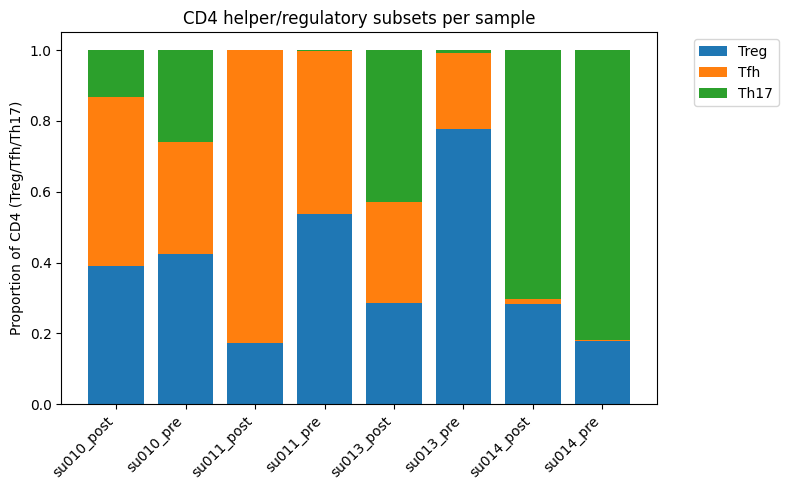

In [24]:
comp_cd4 = (
    obs_cd4.groupby(["patient", "treatment", "cd4_state3"])
           .size()
           .reset_index(name="n_cells")
)

comp_cd4["sample"] = comp_cd4["patient"] + "_" + comp_cd4["treatment"]

pivot_cd4 = comp_cd4.pivot_table(index="cd4_state3",
                                 columns="sample",
                                 values="n_cells",
                                 fill_value=0)

col_sums = pivot_cd4.sum(axis=0)
pivot_cd4_prop = pivot_cd4 / col_sums

# 固定顺序（可调整）
cd4_order = ["Treg", "Tfh", "Th17"]
pivot_cd4_prop = pivot_cd4_prop.loc[cd4_order]

fig, ax = plt.subplots(figsize=(8, 5))

bottom = np.zeros(len(pivot_cd4_prop.columns))
x = np.arange(len(pivot_cd4_prop.columns))

for state in pivot_cd4_prop.index:
    values = pivot_cd4_prop.loc[state].values
    ax.bar(x, values, bottom=bottom, label=state)
    bottom += values

ax.set_xticks(x)
ax.set_xticklabels(pivot_cd4_prop.columns, rotation=45, ha="right")
ax.set_ylabel("Proportion of CD4 (Treg/Tfh/Th17)")
ax.set_title("CD4 helper/regulatory subsets per sample")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()


In [25]:
import plotly.graph_objects as go
import plotly.express as px

# 为每个病人分配不同颜色（Dark24 调色板）
patient_list = sorted(counts_wide["patient"].unique())
palette = px.colors.qualitative.Dark24
color_map = {p: palette[i % len(palette)] for i, p in enumerate(patient_list)}

fig = go.Figure()

for patient_id, df_pat in counts_wide.groupby("patient"):
    df_pre  = df_pat[df_pat["treatment"] == "pre"]
    df_post = df_pat[df_pat["treatment"] == "post"]
    if df_pre.empty or df_post.empty:
        continue

    pre = df_pre.iloc[0]
    post = df_post.iloc[0]

    color = color_map[patient_id]

    # ---- 1. pre→post line ----
    fig.add_trace(
        go.Scatterternary(
            a=[pre["CD8_mem"], post["CD8_mem"]],
            b=[pre["CD8_act_eff"],   post["CD8_act_eff"]],
            c=[pre["CD8_ex"],  post["CD8_ex"]],
            mode="lines",
            line=dict(width=2, color=color),
            showlegend=False
        )
    )

    # ---- 2. pre = circle ----
    fig.add_trace(
        go.Scatterternary(
            a=[pre["CD8_mem"]],
            b=[pre["CD8_act_eff"]],
            c=[pre["CD8_ex"]],
            mode="markers",
            marker=dict(symbol="circle", color=color, size=10),
            name=f"{patient_id} pre"
        )
    )

    # ---- 3. post = square ----
    fig.add_trace(
        go.Scatterternary(
            a=[post["CD8_mem"]],
            b=[post["CD8_act_eff"]],
            c=[post["CD8_ex"]],
            mode="markers",
            marker=dict(symbol="square", color=color, size=12),
            name=f"{patient_id} post"
        )
    )

fig.update_layout(
    ternary=dict(
        sum=1,
        aaxis=dict(title="CD8_mem_total"),
        baxis=dict(title="CD8_act_eff"),
        caxis=dict(title="CD8_ex_total"),
    ),
    title="CD8 functional state composition per patient (pre → post)",
    legend_title_text="Patient"
)

fig.show()

FiLM parameters interpretation

残差衡量每个原型的样本异质性，连续结构，gamma和beta解释由哪些基因主导了这些原型的异质性
- 不同细胞类型内的film参数反映由不同基因主导的方向变化

In [26]:
import numpy as np
import pandas as pd

# 你已有的 obs 设置
obs = adata.obs.copy()

cd8_mask = obs["cluster"].str.startswith("CD8_")
obs_cd8 = obs[cd8_mask].copy()

obs_cd8["cd8_state3"] = np.nan
obs_cd8.loc[obs_cd8["cluster"].isin(["CD8_mem", "CD8_naive"]), "cd8_state3"] = "CD8_mem"
obs_cd8.loc[obs_cd8["cluster"].isin(["CD8_act", "CD8_eff"]),  "cd8_state3"] = "CD8_act_eff"
obs_cd8.loc[obs_cd8["cluster"].isin(["CD8_ex", "CD8_ex_act"]), "cd8_state3"] = "CD8_ex"

obs_cd8 = obs_cd8.dropna(subset=["cd8_state3"])

# 加入到 adata.obs（非 CD8 的设为 NA）
adata.obs["cd8_state3"] = np.nan
adata.obs.loc[obs_cd8.index, "cd8_state3"] = obs_cd8["cd8_state3"]
adata

AnnData object with n_obs × n_vars = 14820 × 5000
    obs: 'patient', 'treatment', 'cluster', 'UMAP1', 'UMAP2', 'cdr3s_nt', 'cdr3s_aa', 'receptor_type', 'receptor_subtype', 'chain_pairing', 'clonotype', 'clonotype_size', 'VJ_1_junction_aa', 'VDJ_1_junction_aa', 'alpha_len', 'beta_len', 'cd8_state3'
    var: 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'chain_indices', 'clonotype', 'cluster_colors', 'hvg', 'ir_dist_nt_identity', 'log1p', 'patient_colors', 'treatment_colors', 'neighbors', 'umap', 'pca'
    obsm: 'airr', 'alpha_mask', 'alpha_seq', 'beta_mask', 'beta_seq', 'chain_indices', 'htcell', 'htcr', 'hgex', 'base_tcells', 'bias_gexs', 'gammas', 'betas', 'indices', 'X_umap', 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [27]:
adata_cd8 = adata[adata.obs["cd8_state3"].isin(["CD8_act_eff", "CD8_ex"])].copy()

In [28]:
import scanpy as sc

sc.tl.rank_genes_groups(
    adata_cd8,
    groupby="cd8_state3",
    groups=["CD8_ex"],
    reference="CD8_act_eff",
    method="wilcoxon"
)

de = sc.get.rank_genes_groups_df(adata_cd8, group="CD8_ex")
de = de.set_index("names")
de

scores  logfoldchanges          pvals      pvals_adj
names                                                          
CD7     37.313805        2.020852  9.801518e-305  4.900759e-301
CD8A    33.683510        2.484700  1.008023e-248  2.520058e-245
CREM    29.608919        2.338547  1.147150e-192  1.433937e-189
FTH1    29.509039        1.384101  2.204349e-191  2.204349e-188
GALNT2  29.326094        2.962697  4.822395e-189  4.018662e-186
...           ...             ...            ...            ...
DNAJA1 -24.298655       -1.387335  2.025594e-130  6.751980e-128
CD48   -26.349524       -1.975451  5.197239e-153  2.165516e-150
DNAJB1 -26.640366       -2.822180  2.314312e-156  1.051960e-153
HSPA1B -28.500793       -3.901223  1.145190e-178  7.157440e-176
HSPA1A -33.223885       -3.842103  4.866636e-242  8.111060e-239

[5000 rows x 4 columns]

In [29]:
sig_genes_ex = de.query("logfoldchanges > 0 and pvals_adj < 0.05").index.tolist()
# 或者取 top 100/200 个 logFC 最大的
sig_genes_ex = (
    de.query("logfoldchanges > 0")
      .sort_values("pvals_adj")
      .head(200).index.tolist()
)
sig_genes_ex

['CD7',
 'CD8A',
 'CREM',
 'FTH1',
 'GALNT2',
 'SLA2',
 'AC092580.4',
 'LDHA',
 'ENTPD1',
 'SAMSN1',
 'CTSW',
 'TIGIT',
 'GABARAPL1',
 'CXCR4',
 'SLC7A5',
 'CD8B',
 'KLRC1',
 'CXCR6',
 'ATP1B3',
 'GNLY',
 'TSC22D3',
 'ITGAE',
 'ZFP36L2',
 'SYTL3',
 'SRGN',
 'RPS26',
 'BIRC3',
 'PTPN22',
 'HLA-A',
 'CXCL13',
 'RALA',
 'DUSP4',
 'TGFB1',
 'LGALS3',
 'PABPC1',
 'LAYN',
 'AHI1',
 'NELL2',
 'FAM177A1',
 'CAMK4',
 'LYST',
 'MT-CYB',
 'SYNGR2',
 'PRF1',
 'RBPJ',
 'NR3C1',
 'CARS',
 'IL7R',
 'PDE4DIP',
 'PBXIP1',
 'IGKC',
 'BTG1',
 'VCAM1',
 'FLNA',
 'STAT5A',
 'SQSTM1',
 'BIRC2',
 'CMIP',
 'PDE4A',
 'LDLRAD4',
 'HAVCR2',
 'CLIC3',
 'JAML',
 'ISG20',
 'MT-ND3',
 'SOX4',
 'MT-CO2',
 'KLRD1',
 'SEC14L1',
 'GLIPR1',
 'NFKB2',
 'DCXR',
 'ITM2A',
 'CAPG',
 'EZR',
 'B2M',
 'MT-CO1',
 'VPS37B',
 'GTF3C1',
 'ACP5',
 'IL2RB',
 'TANK',
 'MT-CO3',
 'PFKFB3',
 'EIF3J',
 'ARID5A',
 'RNF19A',
 'HLA-DRB5',
 'GZMM',
 'NINJ1',
 'PDE4D',
 'CD55',
 'CBLB',
 'PKIA',
 'GZMB',
 'GAPDH',
 'IL9R',
 'IGHG1',
 'GGA2',


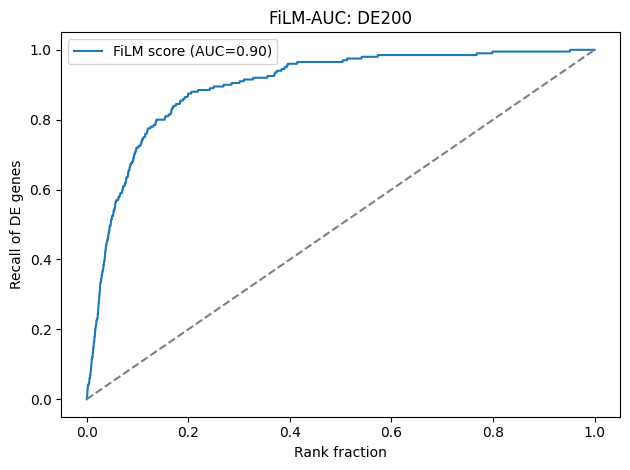

In [30]:
insect_genes = set(sig_genes_ex) & set(adata.var_names)
gammas = adata_cd8.obsm["gammas"]  # 已经是 (1+γ_raw)
betas  = adata_cd8.obsm["betas"]
genes = adata_cd8.var_names
gamma_dev = gammas - 1.0    # 偏离量
beta_dev  = betas   
cells_ex  = adata_cd8.obs["cd8_state3"] == "CD8_ex"
cells_act = adata_cd8.obs["cd8_state3"] == "CD8_act_eff"

g_ex  = gamma_dev[cells_ex].mean(axis=0)
g_act = gamma_dev[cells_act].mean(axis=0)
d_gamma = g_ex - g_act

b_ex  = betas[cells_ex].mean(axis=0)
b_act = betas[cells_act].mean(axis=0)
d_beta = b_ex - b_act

film_score = np.abs(d_gamma) + np.abs(d_beta)
film_score_l2 = np.sqrt(d_gamma**2 + d_beta**2)

fi = pd.DataFrame({
    "gene": genes,
    "d_gamma": d_gamma,
    "d_beta": d_beta,
    "film_score": film_score,
    'film_score_l2':film_score_l2,
}).set_index("gene")

def film_enrichment_curve(score_series, insect_genes):
    score_series = score_series.dropna()
    genes_sorted = score_series.sort_values(ascending=False).index.tolist()
    N = len(genes_sorted)

    hits = np.array([g in insect_genes for g in genes_sorted], dtype=bool)
    recall = np.cumsum(hits) / hits.sum()
    x = np.arange(1, N+1) / N
    auc = np.trapz(recall, x)
    return x, recall, auc
import matplotlib.pyplot as plt

x, y, auc = film_enrichment_curve(fi["film_score"], insect_genes)

plt.plot(x, y, label=f"FiLM score (AUC={auc:.2f})")
plt.plot([0,1],[0,1],'--',color='gray')

plt.xlabel("Rank fraction")
plt.ylabel("Recall of DE genes")
plt.title(f"FiLM-AUC: DE200")
plt.legend()
plt.tight_layout()
plt.show()


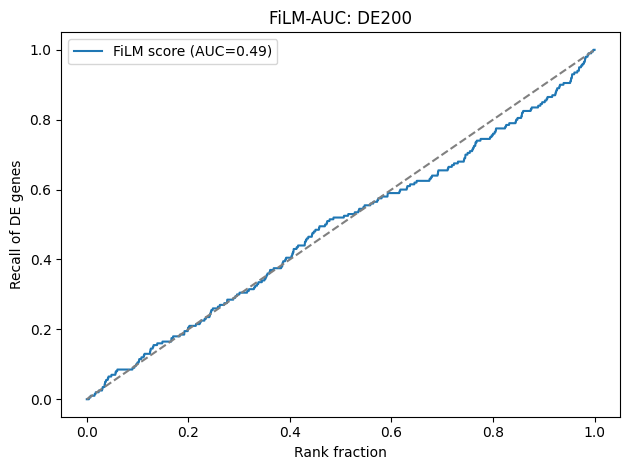

In [31]:
x, y, auc = film_enrichment_curve(fi["d_gamma"], insect_genes)

plt.plot(x, y, label=f"FiLM score (AUC={auc:.2f})")
plt.plot([0,1],[0,1],'--',color='gray')

plt.xlabel("Rank fraction")
plt.ylabel("Recall of DE genes")
plt.title(f"FiLM-AUC: DE200")
plt.legend()
plt.tight_layout()
plt.show()

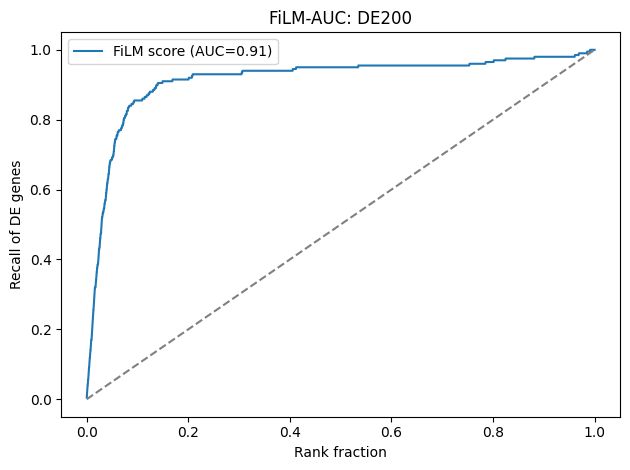

In [32]:
x, y, auc = film_enrichment_curve(fi["d_beta"], insect_genes)

plt.plot(x, y, label=f"FiLM score (AUC={auc:.2f})")
plt.plot([0,1],[0,1],'--',color='gray')

plt.xlabel("Rank fraction")
plt.ylabel("Recall of DE genes")
plt.title(f"FiLM-AUC: DE200")
plt.legend()
plt.tight_layout()
plt.show()

pathway genes hit of top genes in film

In [33]:
def load_gmt(path):
    gene_sets = {}
    with open(path, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            name = parts[0]
            genes = set(parts[2:])
            gene_sets[name] = genes
    return gene_sets

# 使用你的本地文件路径：
gene_sets = load_gmt("h.all.v2025.1.Hs.symbols.gmt")
gene_sets

{'HALLMARK_ADIPOGENESIS': {'ABCA1',
  'ABCB8',
  'ACAA2',
  'ACADL',
  'ACADM',
  'ACADS',
  'ACLY',
  'ACO2',
  'ACOX1',
  'ADCY6',
  'ADIG',
  'ADIPOQ',
  'ADIPOR2',
  'AGPAT3',
  'AIFM1',
  'AK2',
  'ALDH2',
  'ALDOA',
  'ANGPT1',
  'ANGPTL4',
  'APLP2',
  'APOE',
  'ARAF',
  'ARL4A',
  'ATL2',
  'ATP1B3',
  'ATP5PO',
  'BAZ2A',
  'BCKDHA',
  'BCL2L13',
  'BCL6',
  'C3',
  'CAT',
  'CAVIN1',
  'CAVIN2',
  'CCNG2',
  'CD151',
  'CD302',
  'CD36',
  'CDKN2C',
  'CHCHD10',
  'CHUK',
  'CIDEA',
  'CMBL',
  'CMPK1',
  'COL15A1',
  'COL4A1',
  'COQ3',
  'COQ5',
  'COQ9',
  'COX6A1',
  'COX7B',
  'COX8A',
  'CPT2',
  'CRAT',
  'CS',
  'CYC1',
  'CYP4B1',
  'DBT',
  'DDT',
  'DECR1',
  'DGAT1',
  'DHCR7',
  'DHRS7',
  'DHRS7B',
  'DLAT',
  'DLD',
  'DNAJB9',
  'DNAJC15',
  'DRAM2',
  'ECH1',
  'ECHS1',
  'ELMOD3',
  'ELOVL6',
  'ENPP2',
  'EPHX2',
  'ESRRA',
  'ESYT1',
  'ETFB',
  'FABP4',
  'FAH',
  'FZD4',
  'G3BP2',
  'GADD45A',
  'GBE1',
  'GHITM',
  'GPAM',
  'GPAT4',
  'GPD2',
  'GPHN

In [34]:
pathway = "HALLMARK_INTERFERON_GAMMA_RESPONSE"
pathway_genes = gene_sets[pathway] & set(adata.var_names)
len(pathway_genes)

114

In [35]:
gammas = adata_cd8.obsm["gammas"]  # 已经是 (1+γ_raw)
betas  = adata_cd8.obsm["betas"]
genes = adata_cd8.var_names
gamma_dev = gammas - 1.0    # 偏离量
beta_dev  = betas           # 偏离量

In [36]:
cells_ex  = adata_cd8.obs["cd8_state3"] == "CD8_ex"
cells_act = adata_cd8.obs["cd8_state3"] == "CD8_act_eff"

g_ex  = gamma_dev[cells_ex].mean(axis=0)
g_act = gamma_dev[cells_act].mean(axis=0)
d_gamma = g_ex - g_act

b_ex  = betas[cells_ex].mean(axis=0)
b_act = betas[cells_act].mean(axis=0)
d_beta = b_ex - b_act

film_score = np.abs(d_gamma) + np.abs(d_beta)
film_score_l2 = np.sqrt(d_gamma**2 + d_beta**2)

fi = pd.DataFrame({
    "gene": genes,
    "d_gamma": d_gamma,
    "d_beta": d_beta,
    "film_score": film_score,
    'film_score_l2':film_score_l2,
}).set_index("gene")
fi

d_gamma    d_beta  film_score  film_score_l2
gene                                                        
RP11-34P13.7  -0.001817 -0.002941    0.004757       0.003456
FO538757.2    -0.000260  0.009386    0.009646       0.009389
RP11-206L10.9  0.004313 -0.002521    0.006834       0.004996
LINC00115     -0.000046 -0.010126    0.010172       0.010126
KLHL17         0.001363  0.001225    0.002589       0.001833
...                 ...       ...         ...            ...
RP5-855D21.2   0.002123 -0.004333    0.006455       0.004825
SCARA5        -0.000146 -0.002683    0.002829       0.002687
SCN2B          0.001161  0.000677    0.001838       0.001344
CTA-212A2.3    0.000098  0.003657    0.003755       0.003658
RP1-153P14.5  -0.003230  0.000005    0.003235       0.003230

[5000 rows x 4 columns]

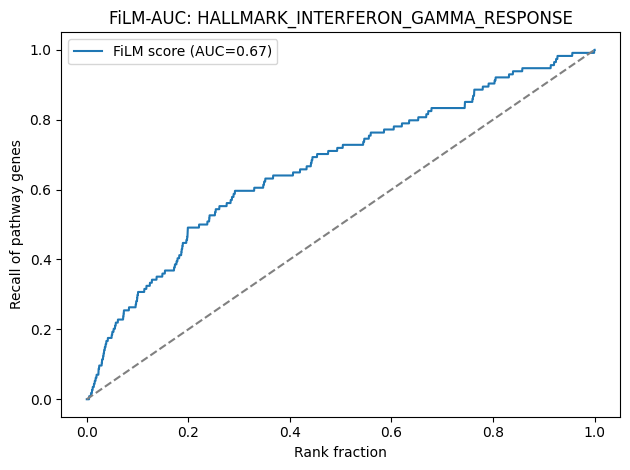

In [37]:
def film_enrichment_curve(score_series, pathway_genes):
    score_series = score_series.dropna()
    genes_sorted = score_series.sort_values(ascending=False).index.tolist()
    N = len(genes_sorted)

    hits = np.array([g in pathway_genes for g in genes_sorted], dtype=bool)
    recall = np.cumsum(hits) / hits.sum()
    x = np.arange(1, N+1) / N
    auc = np.trapz(recall, x)
    return x, recall, auc
import matplotlib.pyplot as plt

x, y, auc = film_enrichment_curve(fi["film_score"], pathway_genes)

plt.plot(x, y, label=f"FiLM score (AUC={auc:.2f})")
plt.plot([0,1],[0,1],'--',color='gray')

plt.xlabel("Rank fraction")
plt.ylabel("Recall of pathway genes")
plt.title(f"FiLM-AUC: {pathway}")
plt.legend()
plt.tight_layout()
plt.show()


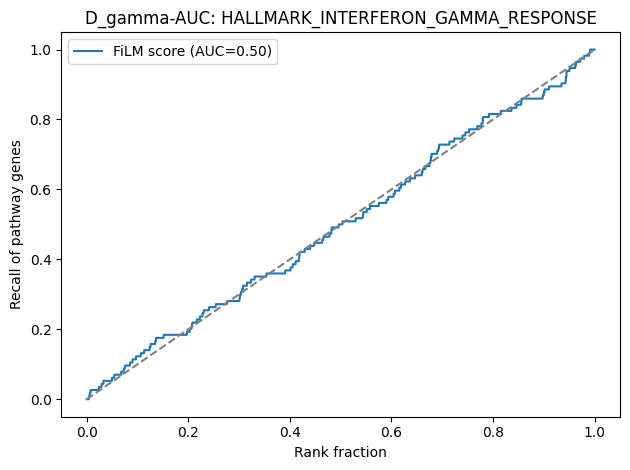

In [38]:
x, y, auc = film_enrichment_curve(fi['d_gamma'], pathway_genes)

plt.plot(x, y, label=f"FiLM score (AUC={auc:.2f})")
plt.plot([0,1],[0,1],'--',color='gray')

plt.xlabel("Rank fraction")
plt.ylabel("Recall of pathway genes")
plt.title(f"D_gamma-AUC: {pathway}")
plt.legend()
plt.tight_layout()
plt.show()

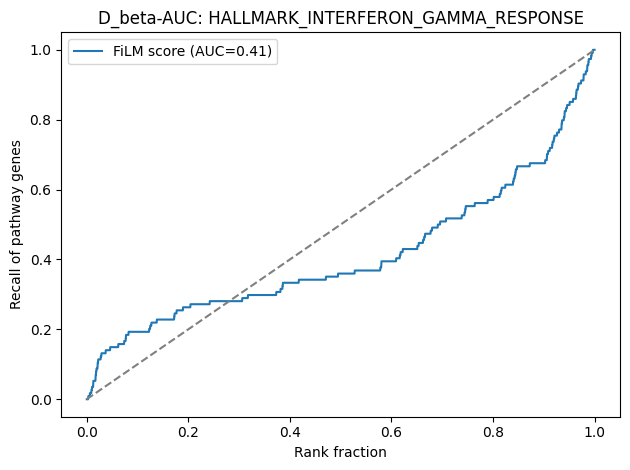

In [39]:
x, y, auc = film_enrichment_curve(fi['d_beta'], pathway_genes)

plt.plot(x, y, label=f"FiLM score (AUC={auc:.2f})")
plt.plot([0,1],[0,1],'--',color='gray')

plt.xlabel("Rank fraction")
plt.ylabel("Recall of pathway genes")
plt.title(f"D_beta-AUC: {pathway}")
plt.legend()
plt.tight_layout()
plt.show()

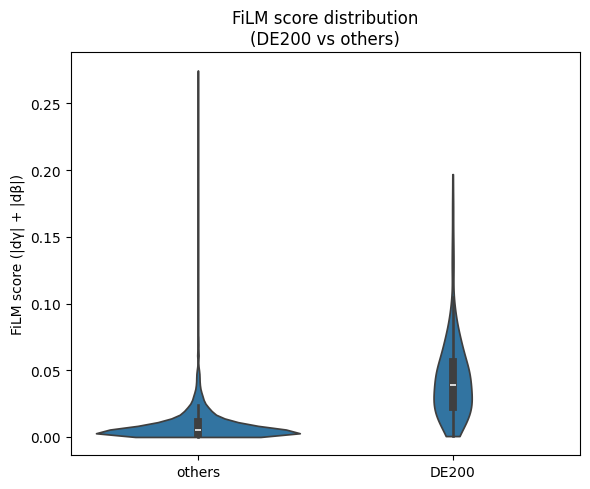

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 假设你已经有：
# fi: DataFrame(index=gene, columns=["d_gamma","d_beta","film_score"])
# sig_genes_ex: list of top200 DE基因

fi_plot = fi.copy()
fi_plot["group"] = ["DE200" if g in sig_genes_ex else "others" for g in fi_plot.index]

plt.figure(figsize=(6,5))
sns.violinplot(data=fi_plot, x="group", y="film_score", cut=0, inner="box")
plt.title("FiLM score distribution\n(DE200 vs others)")
plt.ylabel("FiLM score (|dγ| + |dβ|)")
plt.xlabel("")
plt.tight_layout()
plt.show()


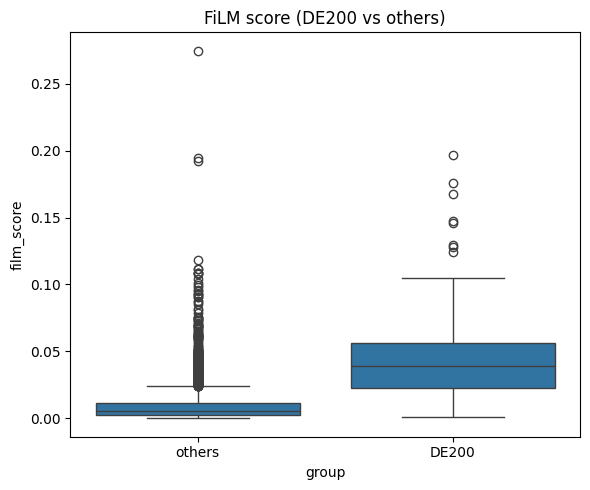

In [41]:
plt.figure(figsize=(6,5))
sns.boxplot(data=fi_plot, x="group", y="film_score")
plt.title("FiLM score (DE200 vs others)")
plt.tight_layout()
plt.show()


In [42]:
fi

d_gamma    d_beta  film_score  film_score_l2
gene                                                        
RP11-34P13.7  -0.001817 -0.002941    0.004757       0.003456
FO538757.2    -0.000260  0.009386    0.009646       0.009389
RP11-206L10.9  0.004313 -0.002521    0.006834       0.004996
LINC00115     -0.000046 -0.010126    0.010172       0.010126
KLHL17         0.001363  0.001225    0.002589       0.001833
...                 ...       ...         ...            ...
RP5-855D21.2   0.002123 -0.004333    0.006455       0.004825
SCARA5        -0.000146 -0.002683    0.002829       0.002687
SCN2B          0.001161  0.000677    0.001838       0.001344
CTA-212A2.3    0.000098  0.003657    0.003755       0.003658
RP1-153P14.5  -0.003230  0.000005    0.003235       0.003230

[5000 rows x 4 columns]

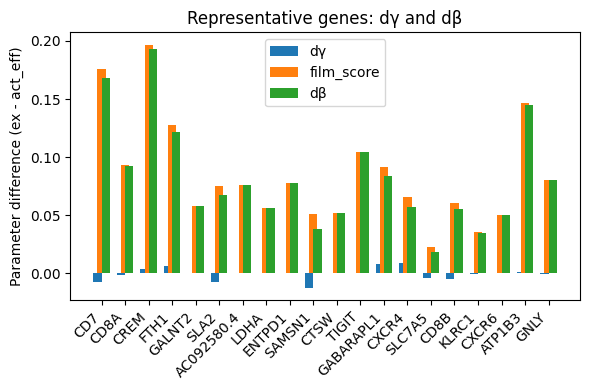

In [43]:

import numpy as np
import matplotlib.pyplot as plt

genes_to_plot = sig_genes_ex[:20]

df_small = fi.loc[genes_to_plot, ["d_gamma", "d_beta", 'film_score']]

plt.figure(figsize=(6,4))
bar_width = 0.35
x = np.arange(len(genes_to_plot))

plt.bar(x - bar_width/2, df_small["d_gamma"], bar_width, label="dγ")
plt.bar(x , df_small["film_score"],  bar_width, label="film_score")
plt.bar(x + bar_width/2, df_small["d_beta"],  bar_width, label="dβ")

plt.xticks(x, genes_to_plot, rotation=45, ha="right")
plt.ylabel("Parameter difference (ex - act_eff)")
plt.title("Representative genes: dγ and dβ")
plt.legend()
plt.tight_layout()
plt.show()


CD8_ex on post and pre

In [44]:
import numpy as np
import pandas as pd
import scanpy as sc

# 只取 CD8_ex 细胞
adata_ex = adata[adata.obs["cd8_state3"] == "CD8_ex"].copy()

# 查看 treatment 的 unique 值
adata_ex.obs["treatment"].value_counts()

groups = ["pre", "post"]

sc.tl.rank_genes_groups(
    adata_ex,
    groupby="treatment",
    groups=["post"],      # post 是目标组
    reference="pre",      # pre 是参考组
    method="wilcoxon"
)

de_tx = sc.get.rank_genes_groups_df(adata_ex, group="post")
de_tx = de_tx.set_index("names")


In [45]:
sig_genes_tx = (
    de_tx.query("logfoldchanges > 0")        # post > pre
         .sort_values("pvals_adj")
         .head(200)
         .index.tolist()
)
len(sig_genes_tx)

200

In [46]:
insect_genes = set(sig_genes_tx) & set(adata.var_names)
insect_genes

{'ADD3',
 'ADK',
 'AOAH',
 'ARL4C',
 'ARL6IP1',
 'ATM',
 'ATP8A1',
 'BBX',
 'BCAT1',
 'BCL3',
 'BEST1',
 'BEX2',
 'BIRC2',
 'BIRC3',
 'C12orf75',
 'CCL4',
 'CCR7',
 'CD27',
 'CD55',
 'CD7',
 'CD8A',
 'CD8B',
 'CDCA7',
 'CH17-373J23.1',
 'CHPT1',
 'CLIC3',
 'CMC1',
 'CMSS1',
 'CMTM7',
 'CNIH1',
 'CNN2',
 'COTL1',
 'CPNE2',
 'CPNE7',
 'CST7',
 'CXCR3',
 'DAPK2',
 'DBN1',
 'DENND2D',
 'DKK3',
 'DUSP1',
 'DUSP16',
 'DUSP2',
 'EMP3',
 'ENTPD1',
 'EOMES',
 'EPB41',
 'EPHA4',
 'ERAP2',
 'FAM102A',
 'FAM129A',
 'FAM177A1',
 'FAM65B',
 'FO538757.2',
 'FOS',
 'FOSB',
 'FTH1',
 'FTL',
 'GADD45B',
 'GALNT11',
 'GCHFR',
 'GIMAP7',
 'GLIPR1',
 'GPR171',
 'GRAMD1A',
 'GRAMD1C',
 'GYG1',
 'GYPC',
 'GZMK',
 'GZMM',
 'HCG18',
 'HIST1H2AC',
 'HLA-DPB1',
 'HSH2D',
 'HSPA8',
 'IER2',
 'IGHA1',
 'IGHG1',
 'IGKC',
 'IGKV3-15',
 'IGKV3-20',
 'IGLC2',
 'IGLC3',
 'IGLV2-14',
 'IKZF2',
 'IL7R',
 'IL9R',
 'KDM7A',
 'KIAA0319L',
 'KLF2',
 'KLF6',
 'KLRC2',
 'LAT',
 'LDLRAD4',
 'LGALS3',
 'LIMS1',
 'LINC00623',
 'L

In [47]:
gammas = adata_ex.obsm["gammas"]
betas  = adata_ex.obsm["betas"]
genes  = adata_ex.var_names
cells_pre  = adata_ex.obs["treatment"] == "pre"
cells_post = adata_ex.obs["treatment"] == "post"

gamma_pre  = gammas[cells_pre].mean(axis=0)
gamma_post = gammas[cells_post].mean(axis=0)
beta_pre   = betas[cells_pre].mean(axis=0)
beta_post  = betas[cells_post].mean(axis=0)

d_gamma_tx = gamma_post - gamma_pre    # post - pre
d_beta_tx  = beta_post  - beta_pre
film_score_tx = np.abs(d_gamma_tx) + np.abs(d_beta_tx)
fi_tx = pd.DataFrame({
    "gene": genes,
    "d_gamma": d_gamma_tx,
    "d_beta": d_beta_tx,
    "film_score": film_score_tx
}).set_index("gene")



In [48]:
def film_enrichment_curve(score_series, pathway_genes):
    score_series = score_series.dropna()
    genes_sorted = score_series.sort_values(ascending=False).index.tolist()
    N = len(genes_sorted)

    hits = np.array([g in pathway_genes for g in genes_sorted], dtype=bool)
    recall = np.cumsum(hits) / hits.sum()
    x = np.arange(1, N+1) / N
    auc = np.trapz(recall, x)
    return x, recall, auc

x, y, auc_tx = film_enrichment_curve(fi_tx["film_score"], insect_genes)
print("FiLM-AUC (post vs pre in CD8_ex) =", auc_tx)


FiLM-AUC (post vs pre in CD8_ex) = 0.707212


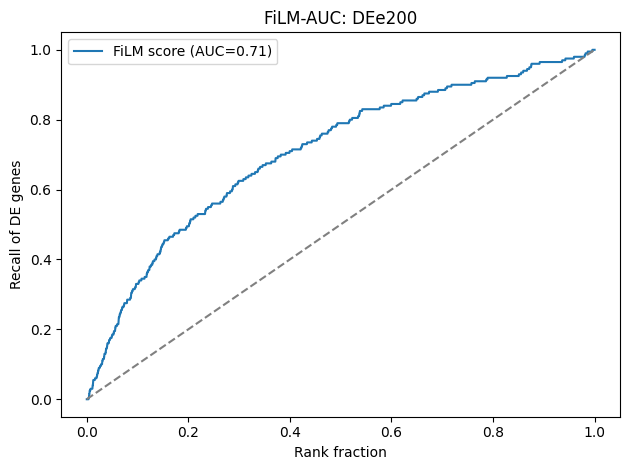

In [49]:

plt.plot(x, y, label=f"FiLM score (AUC={auc_tx:.2f})")
plt.plot([0,1],[0,1],'--',color='gray')

plt.xlabel("Rank fraction")
plt.ylabel("Recall of DE genes")
plt.title(f"FiLM-AUC: DEe200")
plt.legend()
plt.tight_layout()
plt.show()

FiLM-AUC (post vs pre in CD8_ex) = 0.676434


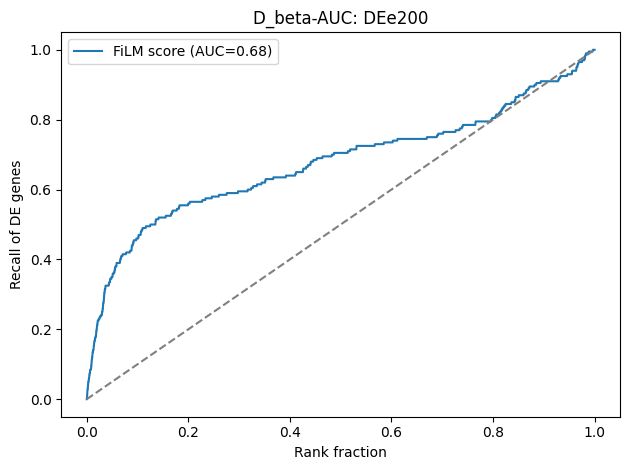

In [50]:
x, y, auc_tx = film_enrichment_curve(fi_tx["d_beta"], insect_genes)
print("FiLM-AUC (post vs pre in CD8_ex) =", auc_tx)
plt.plot(x, y, label=f"FiLM score (AUC={auc_tx:.2f})")
plt.plot([0,1],[0,1],'--',color='gray')

plt.xlabel("Rank fraction")
plt.ylabel("Recall of DE genes")
plt.title(f"D_beta-AUC: DEe200")
plt.legend()
plt.tight_layout()
plt.show()

FiLM-AUC (post vs pre in CD8_ex) = 0.5407580000000001


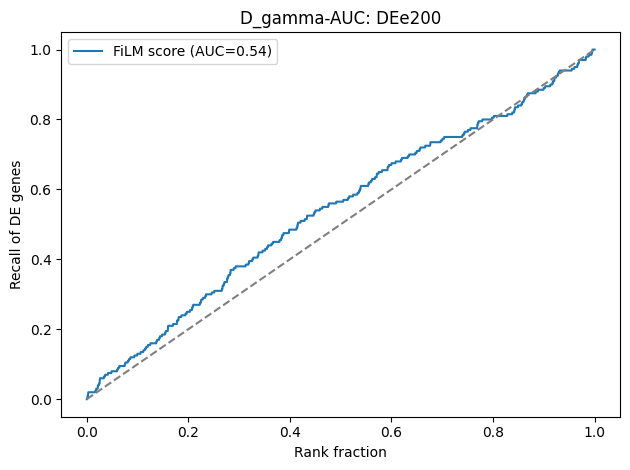

In [51]:
x, y, auc_tx = film_enrichment_curve(fi_tx["d_gamma"], insect_genes)
print("FiLM-AUC (post vs pre in CD8_ex) =", auc_tx)
plt.plot(x, y, label=f"FiLM score (AUC={auc_tx:.2f})")
plt.plot([0,1],[0,1],'--',color='gray')

plt.xlabel("Rank fraction")
plt.ylabel("Recall of DE genes")
plt.title(f"D_gamma-AUC: DEe200")
plt.legend()
plt.tight_layout()
plt.show()

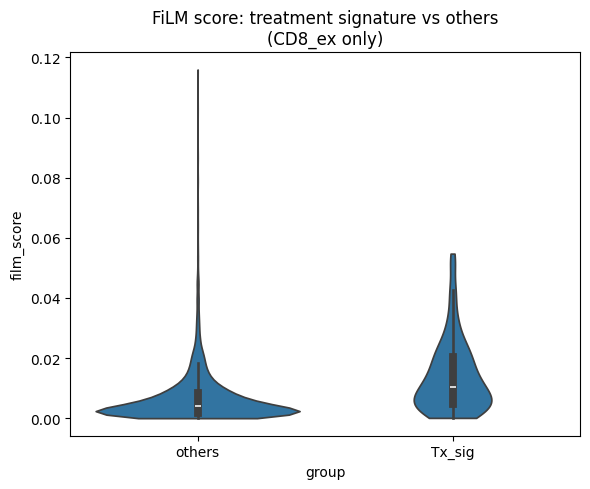

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

fi_plot_tx = fi_tx.copy()
fi_plot_tx["group"] = ["Tx_sig" if g in sig_genes_tx else "others"
                       for g in fi_plot_tx.index]

plt.figure(figsize=(6,5))
sns.violinplot(data=fi_plot_tx, x="group", y="film_score", cut=0, inner="box")
plt.title("FiLM score: treatment signature vs others\n(CD8_ex only)")
plt.tight_layout()
plt.show()


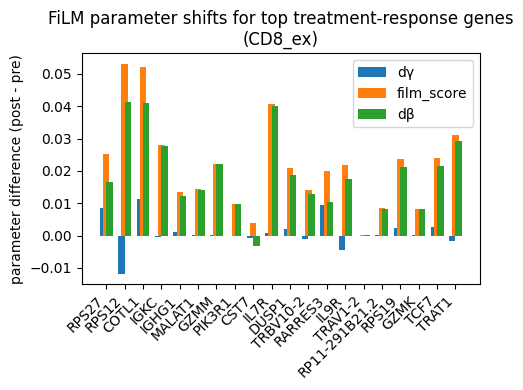

In [53]:
top_tx_genes = sig_genes_tx[:20]  # 你也可以选任意感兴趣的基因

df_small_tx = fi_tx.loc[top_tx_genes, ["d_gamma", "d_beta","film_score"]]

plt.figure(figsize=(5,4))
x = np.arange(len(top_tx_genes))
bar_width = 0.35
plt.bar(x - bar_width/2, df_small_tx["d_gamma"], bar_width, label="dγ")
plt.bar(x , df_small_tx["film_score"],  bar_width, label="film_score")
plt.bar(x + bar_width/2, df_small_tx["d_beta"],  bar_width, label="dβ")

plt.xticks(x, top_tx_genes, rotation=45, ha="right")
plt.ylabel("parameter difference (post - pre)")
plt.title("FiLM parameter shifts for top treatment-response genes\n(CD8_ex)")
plt.legend()
plt.tight_layout()
plt.show()


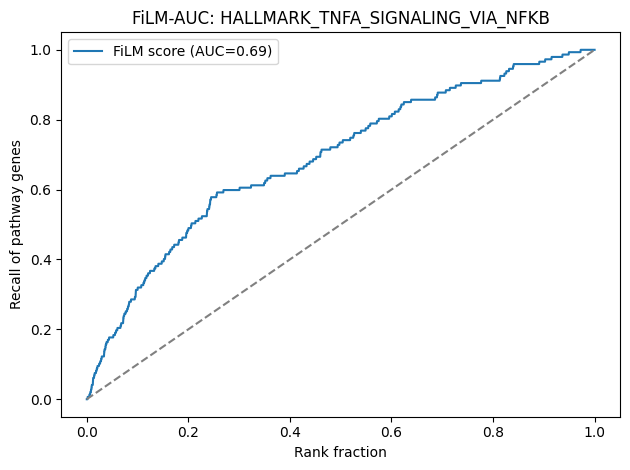

In [54]:
pathway = "HALLMARK_TNFA_SIGNALING_VIA_NFKB"
# HALLMARK_TNFA_SIGNALING_VIA_NFKB
pathway_genes = gene_sets[pathway] & set(adata.var_names)
len(pathway_genes)
def film_enrichment_curve(score_series, pathway_genes):
    score_series = score_series.dropna()
    genes_sorted = score_series.sort_values(ascending=False).index.tolist()
    N = len(genes_sorted)

    hits = np.array([g in pathway_genes for g in genes_sorted], dtype=bool)
    recall = np.cumsum(hits) / hits.sum()
    x = np.arange(1, N+1) / N
    auc = np.trapz(recall, x)
    return x, recall, auc
import matplotlib.pyplot as plt

x, y, auc = film_enrichment_curve(fi["film_score"], pathway_genes)

plt.plot(x, y, label=f"FiLM score (AUC={auc:.2f})")
plt.plot([0,1],[0,1],'--',color='gray')

plt.xlabel("Rank fraction")
plt.ylabel("Recall of pathway genes")
plt.title(f"FiLM-AUC: {pathway}")
plt.legend()
plt.tight_layout()
plt.show()

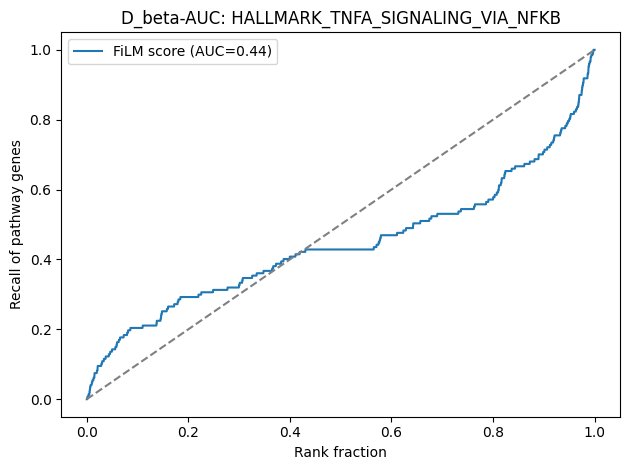

In [55]:
x, y, auc = film_enrichment_curve(fi["d_beta"], pathway_genes)

plt.plot(x, y, label=f"FiLM score (AUC={auc:.2f})")
plt.plot([0,1],[0,1],'--',color='gray')

plt.xlabel("Rank fraction")
plt.ylabel("Recall of pathway genes")
plt.title(f"D_beta-AUC: {pathway}")
plt.legend()
plt.tight_layout()
plt.show()

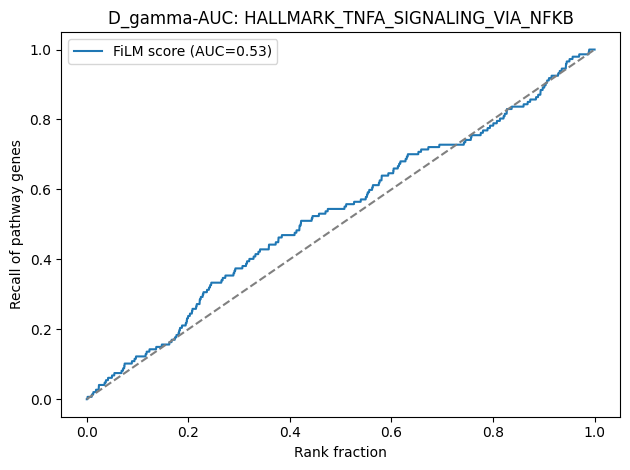

In [56]:
x, y, auc = film_enrichment_curve(fi["d_gamma"], pathway_genes)

plt.plot(x, y, label=f"FiLM score (AUC={auc:.2f})")
plt.plot([0,1],[0,1],'--',color='gray')

plt.xlabel("Rank fraction")
plt.ylabel("Recall of pathway genes")
plt.title(f"D_gamma-AUC: {pathway}")
plt.legend()
plt.tight_layout()
plt.show()

Hot map of indices

In [57]:
adata.obsm['indices']

array([[19, 11],
       [52, 22],
       [48,  7],
       ...,
       [10, 30],
       [40, 45],
       [23, 48]])

<Figure size 1000x800 with 0 Axes>

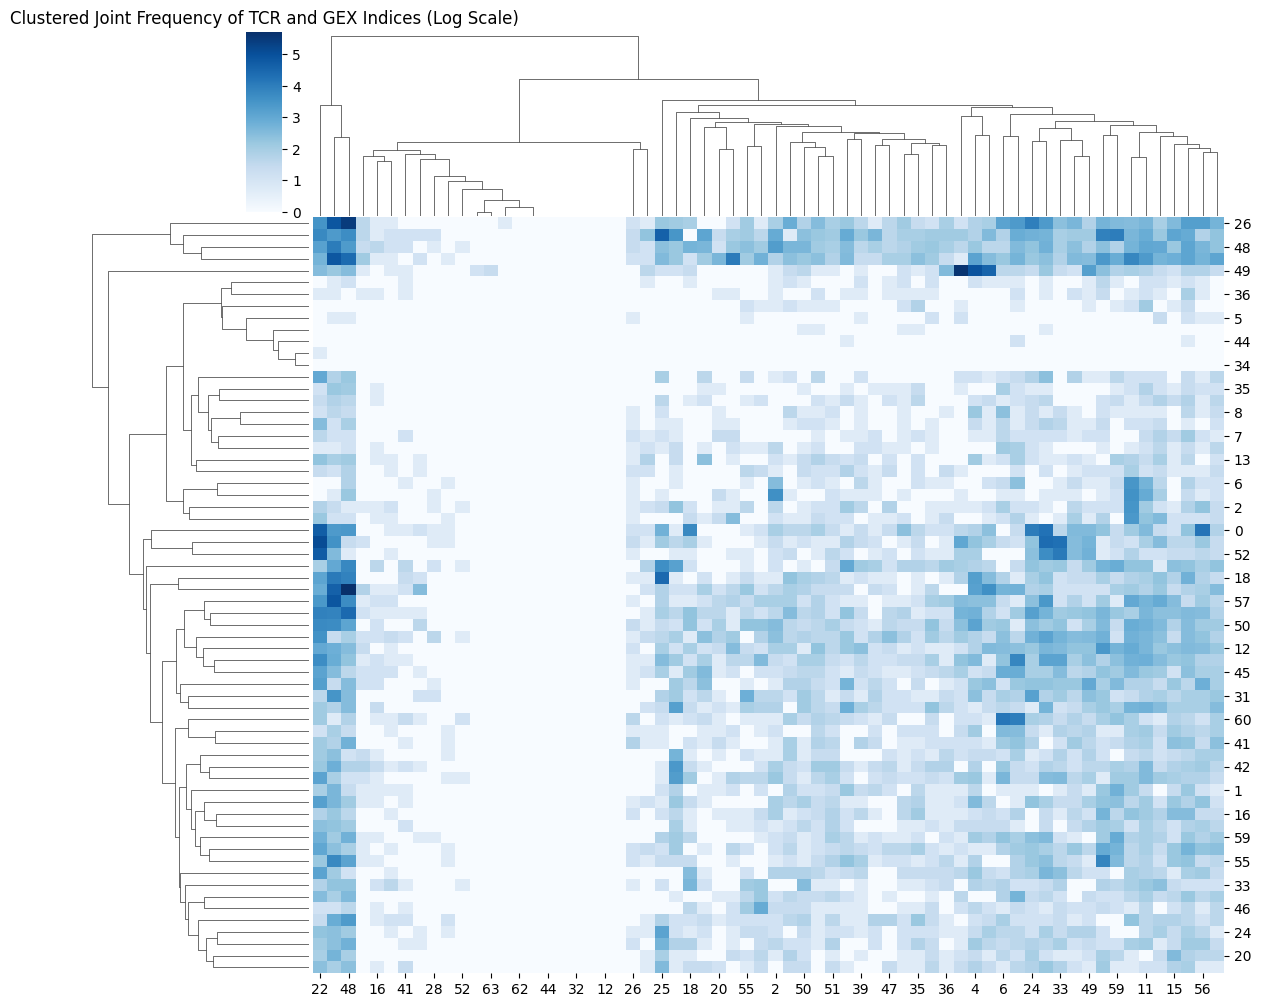

In [58]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
indices = adata.obsm['indices']  # 获取数据

# 提取 TCR 和 GEX 索引
TCR_index = indices[:, 0]  # 第一列是 TCR 索引
GEX_index = indices[:, 1]  # 第二列是 GEX 索引

# 计算联合频率矩阵
joint_frequency = np.zeros((max(TCR_index) + 1, max(GEX_index) + 1)) 
for tcr, gex in zip(TCR_index, GEX_index):
    joint_frequency[tcr, gex] += 1
# 对频率矩阵进行对数变换
log_joint_frequency = np.log1p(joint_frequency)  # 使用 log(1 + x) 来避免对零值进行对数计算

# 聚类热图
plt.figure(figsize=(10, 8))
sns.clustermap(log_joint_frequency, cmap="Blues", figsize=(12, 10), annot=False, fmt=".2f", 
               cbar_pos=(0.15, 0.8, 0.03, 0.18))
plt.title("Clustered Joint Frequency of TCR and GEX Indices (Log Scale)")
plt.show()


In [59]:
adata.obs.patient.value_counts()

su010    5355
su011    4000
su013    3126
su014    2339
Name: patient, dtype: int64

In [70]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

# ---- 1. 从 adata.obsm 取出 PQ 索引 ----
codes = adata.obsm["indices"]          # shape = (n_cells, 2)
assert codes.shape[1] == 2

# 假定 0 维是 TCR, 1 维是 GEX；如果你反过来，就把这两行对调
adata.obs["tcr_idx"] = codes[:, 0].astype(int)
adata.obs["gex_idx"] = codes[:, 1].astype(int)

# 你的设定是每个子空间 K = 64
K_TCR = 64
K_GEX = 64

# 只保留在 0~63 范围内的索引（以防有越界）
obs = adata.obs.copy()
obs = obs.query("0 <= tcr_idx < @K_TCR and 0 <= gex_idx < @K_GEX")

# ---- 2. 定义响应 / 非响应病人 ----
resp_patients     = ["su010", "su011"]
nonresp_patients  = ["su013", "su014"]

def label_group(p):
    if p in resp_patients:
        return "response"
    elif p in nonresp_patients:
        return "non_response"
    else:
        return "other"

obs["group"] = obs["patient"].map(label_group)


In [71]:
def compute_joint_matrix(df, K_tcr=64, K_gex=64):
    """
    df: 包含 tcr_idx, gex_idx 的 DataFrame
    返回: K_tcr x K_gex 的共现矩阵 (numpy array)
    """
    tab = pd.crosstab(df["tcr_idx"], df["gex_idx"])
    tab = tab.reindex(index=range(K_tcr), columns=range(K_gex), fill_value=0)
    return tab.values


In [72]:
def plot_pre_post_heatmaps(joint_pre, joint_post, title_prefix=""):
    log_pre  = np.log1p(joint_pre)
    log_post = np.log1p(joint_post)
    vmax = max(log_pre.max(), log_post.max())

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

    # PRE
    sns.heatmap(
        log_pre,
        ax=axes[0],
        cmap="magma",
        vmin=0,
        vmax=vmax,
        cbar=False,
        square=True,
    )
    axes[0].set_title(f"{title_prefix} PRE")
    axes[0].set_xlabel("GEX index")
    axes[0].set_ylabel("TCR index")

    # POST
    sns.heatmap(
        log_post,
        ax=axes[1],
        cmap="magma",
        vmin=0,
        vmax=vmax,
        cbar_kws={"label": "log1p(count)"},
        square=True,
    )
    axes[1].set_title(f"{title_prefix} POST")
    axes[1].set_xlabel("GEX index")
    axes[1].set_ylabel("")

    plt.tight_layout()
    plt.show()


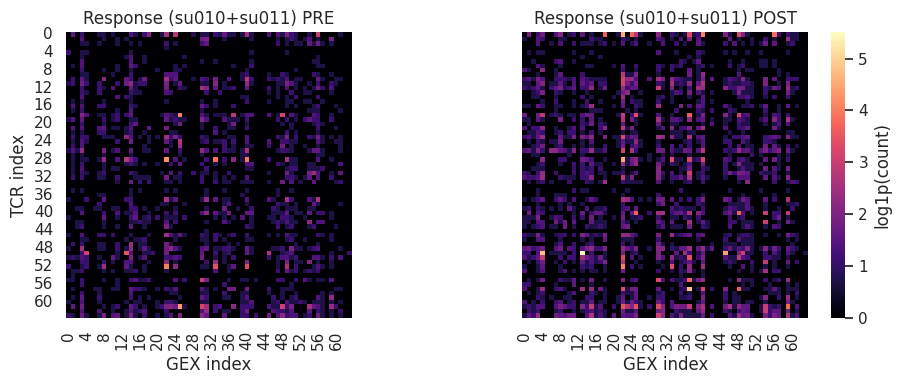

In [74]:
obs_resp = obs[obs["group"] == "response"]

resp_pre  = obs_resp[obs_resp["treatment"] == "pre"]
resp_post = obs_resp[obs_resp["treatment"] == "post"]

joint_resp_pre  = compute_joint_matrix(resp_pre,  K_tcr=K_TCR, K_gex=K_GEX)
joint_resp_post = compute_joint_matrix(resp_post, K_tcr=K_TCR, K_gex=K_GEX)

plot_pre_post_heatmaps(joint_resp_pre, joint_resp_post,
                       title_prefix="Response (su010+su011)")


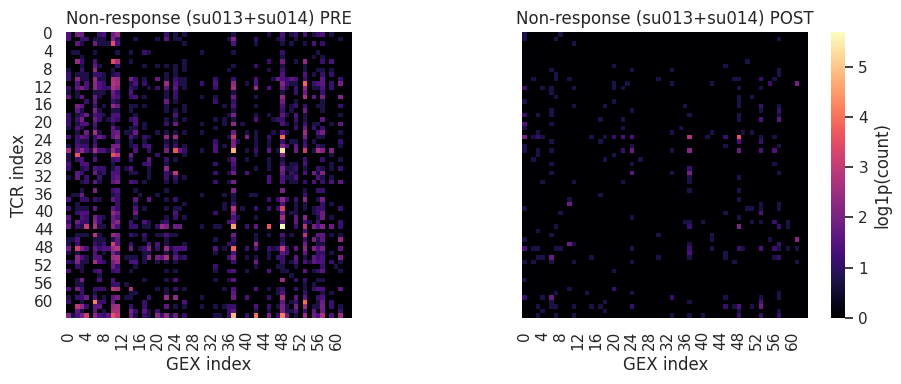

In [75]:
obs_nonresp = obs[obs["group"] == "non_response"]

nonresp_pre  = obs_nonresp[obs_nonresp["treatment"] == "pre"]
nonresp_post = obs_nonresp[obs_nonresp["treatment"] == "post"]

joint_nonresp_pre  = compute_joint_matrix(nonresp_pre,  K_tcr=K_TCR, K_gex=K_GEX)
joint_nonresp_post = compute_joint_matrix(nonresp_post, K_tcr=K_TCR, K_gex=K_GEX)

plot_pre_post_heatmaps(joint_nonresp_pre, joint_nonresp_post,
                       title_prefix="Non-response (su013+su014)")


above heatmap cannot readable, select the most effect

In [76]:
# PQ indices
codes = adata.obsm["indices"]           # (n_cells, 2)
adata.obs["tcr_idx"] = codes[:, 0].astype(int)
adata.obs["gex_idx"] = codes[:, 1].astype(int)


In [77]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

K_TCR = 64
K_GEX = 64

# 只保留合法索引
obs = adata.obs.copy()
obs = obs.query("0 <= tcr_idx < @K_TCR and 0 <= gex_idx < @K_GEX")

# 定义 R / NR 组
resp_patients    = ["su010", "su011"]
nonresp_patients = ["su013", "su014"]

def label_group(p):
    if p in resp_patients:
        return "response"
    elif p in nonresp_patients:
        return "non_response"
    else:
        return "other"

obs["group"] = obs["patient"].map(label_group)

# 分条件切一下
resp_pre  = obs.query("group == 'response' and treatment == 'pre'")
resp_post = obs.query("group == 'response' and treatment == 'post'")
nr_pre    = obs.query("group == 'non_response' and treatment == 'pre'")
nr_post   = obs.query("group == 'non_response' and treatment == 'post'")

def joint_matrix(df, K_tcr=64, K_gex=64):
    tab = pd.crosstab(df["tcr_idx"], df["gex_idx"])
    tab = tab.reindex(index=range(K_tcr), columns=range(K_gex), fill_value=0)
    return tab


In [109]:
def plot_top_block_heatmaps(df_pre, df_post, 
                            title_prefix="Response",
                            top_tcr=10, top_gex=10):
    # 1) 先在 pre+post 合并里选“高频 TCR/GEX code”
    both = pd.concat([df_pre, df_post], axis=0)

    top_tcr_codes = (both["tcr_idx"]
                     .value_counts()
                     .head(top_tcr)
                     .index
                     .tolist())
    top_gex_codes = (both["gex_idx"]
                     .value_counts()
                     .head(top_gex)
                     .index
                     .tolist())

    top_tcr_codes = sorted(top_tcr_codes)
    top_gex_codes = sorted(top_gex_codes)

    # 2) 只保留这些 code 的细胞
    pre_sub  = df_pre[df_pre["tcr_idx"].isin(top_tcr_codes) & 
                      df_pre["gex_idx"].isin(top_gex_codes)]
    post_sub = df_post[df_post["tcr_idx"].isin(top_tcr_codes) & 
                       df_post["gex_idx"].isin(top_gex_codes)]

    mat_pre  = pd.crosstab(pre_sub["tcr_idx"],  pre_sub["gex_idx"])
    mat_post = pd.crosstab(post_sub["tcr_idx"], post_sub["gex_idx"])

    # 补全行列，保证 pre/post 的轴完全一致
    mat_pre  = mat_pre.reindex(index=top_tcr_codes, columns=top_gex_codes, fill_value=0)
    mat_post = mat_post.reindex(index=top_tcr_codes, columns=top_gex_codes, fill_value=0)

    log_pre  = np.log1p(mat_pre.values)
    log_post = np.log1p(mat_post.values)
    vmax = max(log_pre.max(), log_post.max())

    # fig_width = 0.5 * len(top_gex_codes) * 2 + 4  # ×2因为有两个子图
    # fig_height = 0.5 * len(top_tcr_codes) + 4
    plot_width = len(top_gex_codes) * 0.5
    plot_height = len(top_tcr_codes) * 0.5
    total_width = plot_width * 2 + 0.03 + 2
    total_height = plot_height + 2
    # 3) 画 pre / post 并排
    # fig, axes = plt.subplots(
    #     1, 2, 
    #     figsize=(0.5*len(top_gex_codes)+4, 0.5*len(top_tcr_codes)+4),
    #     sharex=True, sharey=True
    # )
    # fig, axes = plt.subplots(
    #     1, 2, 
    #     figsize=(fig_width, fig_height),  # 统一尺寸
    #     sharex=True, 
    #     sharey=True,
    #     gridspec_kw={'width_ratios': [1, 1]}  # 确保两个子图宽度相等
    # )
    fig, axes = plt.subplots(
        1, 2, 
        figsize=(total_width, total_height),
        sharex=True, 
        sharey=True,
        gridspec_kw={'width_ratios': [1, 1.25]}
    )

    sns.heatmap(
        log_pre,
        ax=axes[0],
        cmap="magma",
        vmin=0, vmax=vmax,
        cbar=False,
        xticklabels=top_gex_codes,
        yticklabels=top_tcr_codes,
        square=True,
    )
    axes[0].set_title(f"{title_prefix} PRE\n(top {top_tcr} TCR × top {top_gex} GEX)")
    axes[0].set_xlabel("GEX index")
    axes[0].set_ylabel("TCR index")

    sns.heatmap(
        log_post,
        ax=axes[1],
        cmap="magma",
        vmin=0, vmax=vmax,
        cbar_kws={"label": "log1p(count)"},
        xticklabels=top_gex_codes,
        yticklabels=False,
        square=True,
    )
    axes[1].set_title(f"{title_prefix} POST\n(top {top_tcr} TCR × top {top_gex} GEX)")
    axes[1].set_xlabel("GEX index")

    plt.tight_layout()
    plt.show()


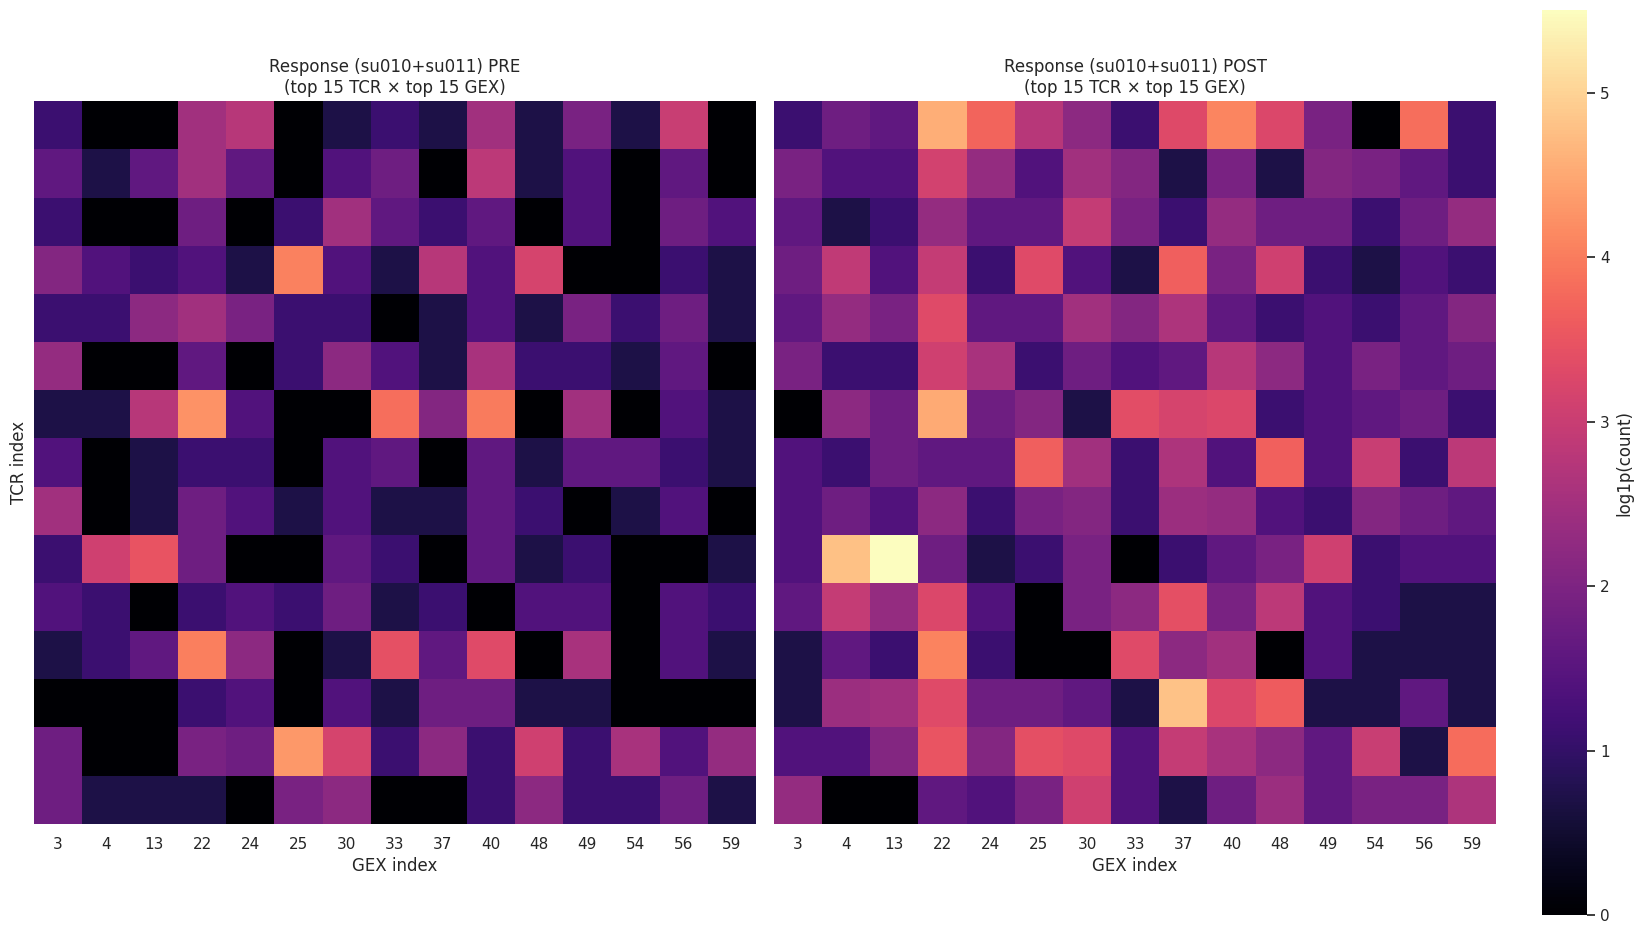

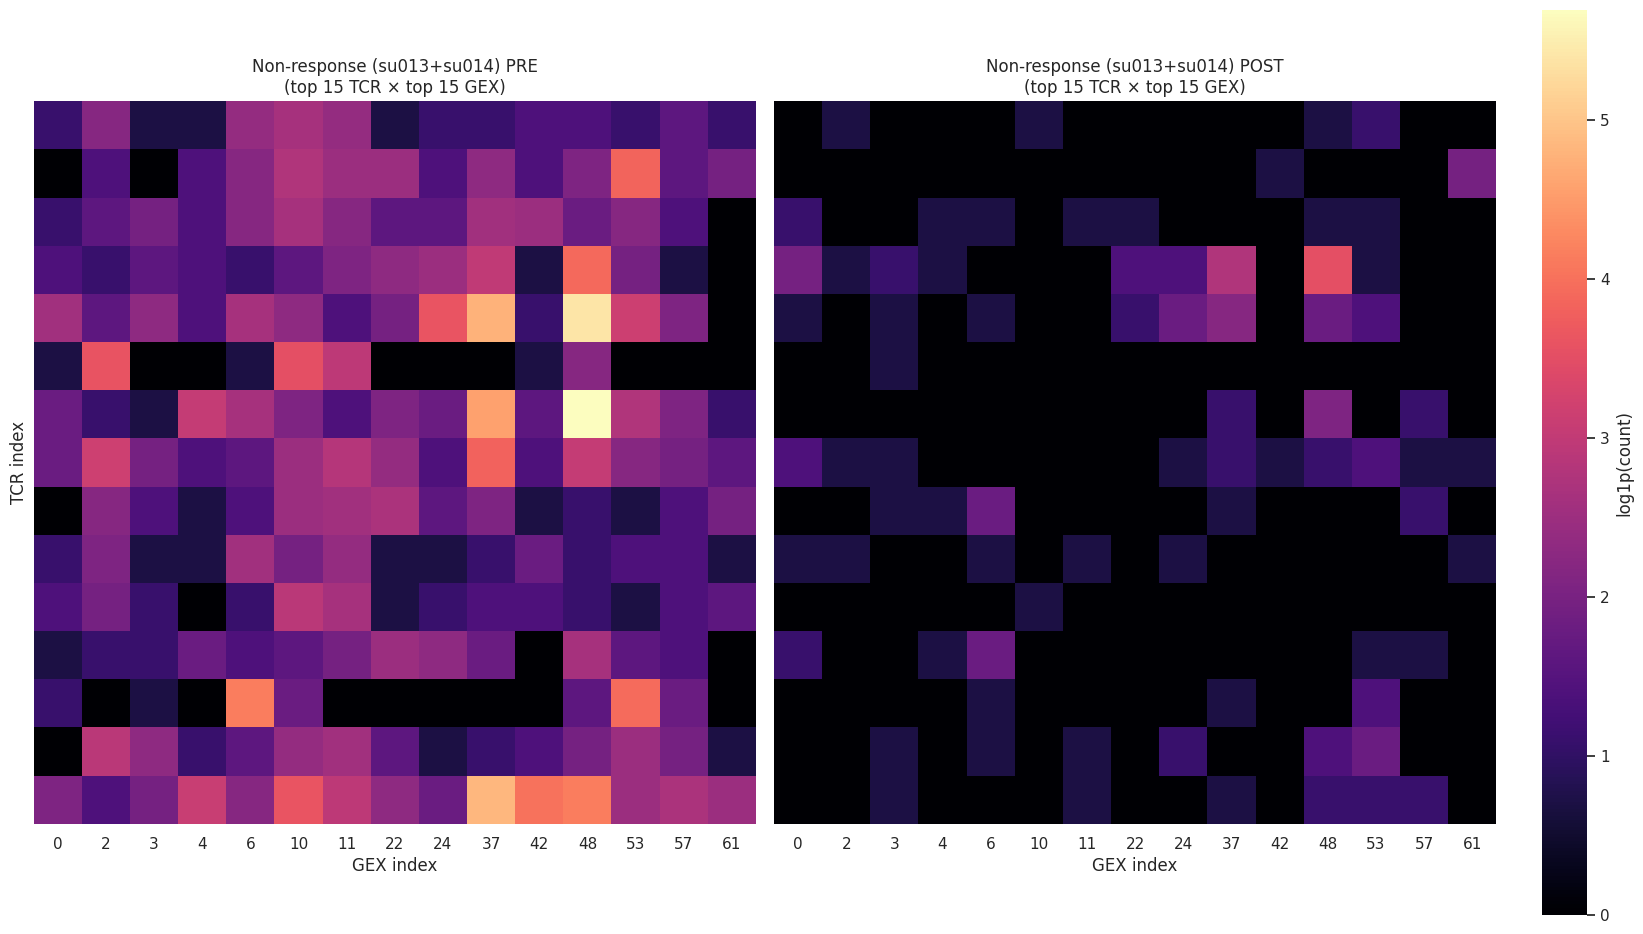

In [110]:
# 响应组：看 clone–state 组合有没有明显换一批
plot_top_block_heatmaps(resp_pre, resp_post, 
                        title_prefix="Response (su010+su011)",
                        top_tcr=15, top_gex=15)

# 非响应组：对照一下
plot_top_block_heatmaps(nr_pre, nr_post, 
                        title_prefix="Non-response (su013+su014)",
                        top_tcr=15, top_gex=15)


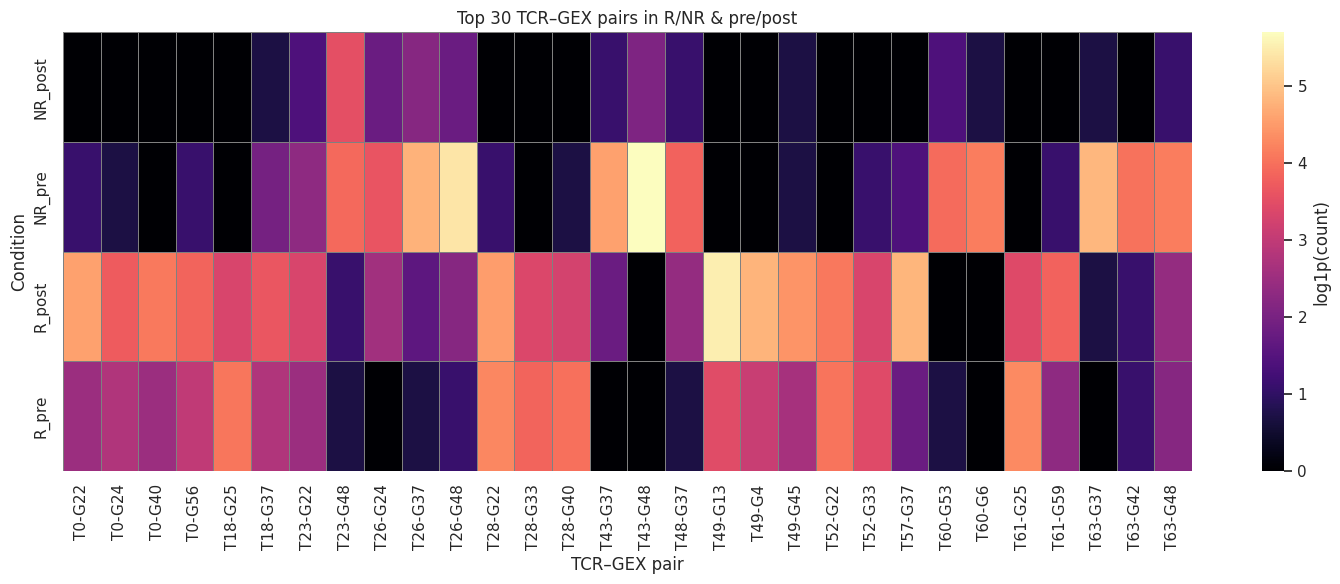

In [87]:
def pair_table(df, cond_label):
    out = (df
           .groupby(["tcr_idx", "gex_idx"])
           .size()
           .rename("count")
           .reset_index())
    out["cond"] = cond_label
    return out

# 四个条件的 pair 计数表
pairs_R_pre  = pair_table(resp_pre,  "R_pre")
pairs_R_post = pair_table(resp_post, "R_post")
pairs_NR_pre = pair_table(nr_pre,    "NR_pre")
pairs_NR_post= pair_table(nr_post,   "NR_post")

pairs_all = pd.concat(
    [pairs_R_pre, pairs_R_post, pairs_NR_pre, pairs_NR_post],
    axis=0,
    ignore_index=True,
)

# 选总 frequency 最高的前 N 个 (TCR,GEX) 组合
TOP_N = 30
top_pairs_idx = (pairs_all
                 .groupby(["tcr_idx", "gex_idx"])["count"]
                 .sum()
                 .sort_values(ascending=False)
                 .head(TOP_N)
                 .index)

pairs_top = (pairs_all
             .set_index(["tcr_idx", "gex_idx"])
             .loc[top_pairs_idx]
             .reset_index())

# 给每个 pair 起个名字，例如 "T12-G7"
pairs_top["pair"] = pairs_top.apply(
    lambda r: f"T{int(r.tcr_idx)}-G{int(r.gex_idx)}", axis=1
)

# 修改这里：把条件放在行，pair放在列
mat = (pairs_top
       .pivot(index="cond", columns="pair", values="count")  # 交换index和columns
       .fillna(0))

log_mat = np.log1p(mat)

# 调整图形尺寸以适应新的方向
plt.figure(figsize=(0.4*len(log_mat.columns)+3, 6))  # 交换宽高

sns.heatmap(
    log_mat,
    cmap="magma",
    cbar_kws={"label": "log1p(count)"},
    linewidths=0.5,
    linecolor="grey",
)

# 调整标题和标签
plt.title(f"Top {TOP_N} TCR–GEX pairs in R/NR & pre/post")
plt.xlabel("TCR–GEX pair")  
plt.ylabel("Condition")  
plt.tight_layout()
plt.show()

In [88]:
# 1. 按GEX分组，看每个GEX原型对应的TCR原型在治疗前后的变化
gex_tcr_changes = []

for condition, df in [("R_pre", resp_pre), ("R_post", resp_post), 
                      ("NR_pre", nr_pre), ("NR_post", nr_post)]:
    gex_groups = df.groupby("gex_idx")
    
    for gex_idx, group in gex_groups:
        # 获取这个GEX对应的主要TCR原型
        tcr_distribution = group["tcr_idx"].value_counts()
        if len(tcr_distribution) > 0:
            dominant_tcr = tcr_distribution.index[0]  # 最主要的TCR
            dominance_ratio = tcr_distribution.iloc[0] / len(group)  # 主导TCR的比例
            
            gex_tcr_changes.append({
                "gex_idx": gex_idx,
                "condition": condition,
                "dominant_tcr": dominant_tcr,
                "n_tcrs": len(tcr_distribution),  # 有多少不同的TCR识别这个GEX
                "dominance_ratio": dominance_ratio,
                "total_cells": len(group)
            })

changes_df = pd.DataFrame(gex_tcr_changes)

# 2. 筛选有足够细胞数的GEX原型进行分析
min_cells_per_gex = 10  # 可以根据数据调整
filtered_gex = (changes_df
               .groupby("gex_idx")["total_cells"]
               .sum()
               .loc[lambda x: x >= min_cells_per_gex]
               .index)

filtered_changes = changes_df[changes_df["gex_idx"].isin(filtered_gex)]

# 3. 重点分析R组治疗前后的变化
r_changes = filtered_changes[filtered_changes["condition"].str.startswith("R")]
pivot_r = r_changes.pivot(index="gex_idx", columns="condition", 
                         values=["dominant_tcr", "n_tcrs", "dominance_ratio"])

# 找出发生了TCR替换的GEX原型
tcr_replacement = []
for gex_idx in pivot_r.index:
    pre_tcr = pivot_r.loc[gex_idx, ("dominant_tcr", "R_pre")]
    post_tcr = pivot_r.loc[gex_idx, ("dominant_tcr", "R_post")]
    
    if pre_tcr != post_tcr:  # 主导TCR发生了变化
        pre_dominance = pivot_r.loc[gex_idx, ("dominance_ratio", "R_pre")]
        post_dominance = pivot_r.loc[gex_idx, ("dominance_ratio", "R_post")]
        pre_ntcrs = pivot_r.loc[gex_idx, ("n_tcrs", "R_pre")]
        post_ntcrs = pivot_r.loc[gex_idx, ("n_tcrs", "R_post")]
        
        tcr_replacement.append({
            "gex_idx": gex_idx,
            "pre_dominant_tcr": pre_tcr,
            "post_dominant_tcr": post_tcr,
            "pre_dominance": pre_dominance,
            "post_dominance": post_dominance,
            "pre_n_tcrs": pre_ntcrs,
            "post_n_tcrs": post_ntcrs,
            "diversity_change": post_ntcrs - pre_ntcrs  # TCR多样性变化
        })

replacement_df = pd.DataFrame(tcr_replacement)

print("发生了TCR克隆替换的GEX原型:")
print(f"总共 {len(replacement_df)} 个GEX原型发生了替换")
print(replacement_df)

发生了TCR克隆替换的GEX原型:
总共 42 个GEX原型发生了替换
    gex_idx  pre_dominant_tcr  post_dominant_tcr  pre_dominance  \
0         0              63.0               18.0       0.125000   
1         1              61.0                0.0       0.078431   
2         2              53.0               21.0       0.166667   
3         3              48.0               63.0       0.075862   
4         6              57.0               26.0       0.500000   
5         7              21.0               26.0       0.078947   
6         8              52.0                0.0       0.117647   
7         9              23.0               43.0       1.000000   
8        10              50.0               63.0       0.153846   
9        11              63.0               26.0       0.083333   
10       14              47.0               48.0       0.058824   
11       15              41.0               61.0       0.100000   
12       16              57.0               40.0       0.086957   
13       17              1

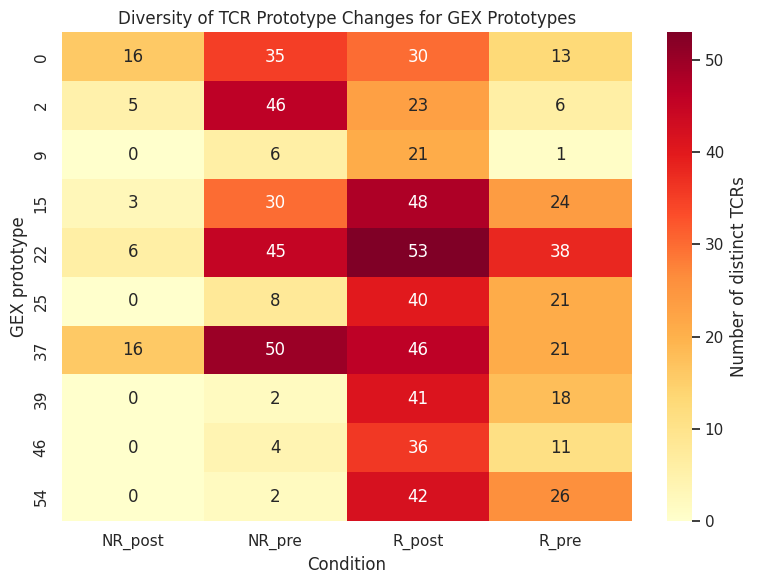

In [91]:
# 可视化发生了替换的GEX原型
if len(replacement_df) > 0:
    # 选择前N个最有代表性的替换案例
    top_replacements = replacement_df.nlargest(min(10, len(replacement_df)), 
                                             "diversity_change")
    
    # 为这些GEX原型创建详细的热图
    selected_gex = top_replacements["gex_idx"].tolist()
    detailed_data = filtered_changes[filtered_changes["gex_idx"].isin(selected_gex)]
    
    # 创建热图展示每个GEX的TCR组成变化
    pivot_detailed = detailed_data.pivot(index="gex_idx", columns="condition", 
                                       values="n_tcrs").fillna(0)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(pivot_detailed, annot=True, cmap="YlOrRd", 
                cbar_kws={"label": "Number of distinct TCRs"})
    plt.title("Diversity of TCR Prototype Changes for GEX Prototypes")
    plt.ylabel("GEX prototype")
    plt.xlabel("Condition")
    plt.tight_layout()
    plt.show()

In [94]:
# 1. 首先重现您的数据处理流程，但关注TCR身份变化
def analyze_clonal_replacement(resp_pre, resp_post, nr_pre, nr_post):
    """分析真正的克隆替换：同一个GEX被不同TCR识别"""
    
    results = []
    
    # 分析每个条件组合
    for condition_name, condition_data in [
        ('R_pre', resp_pre), ('R_post', resp_post),
        ('NR_pre', nr_pre), ('NR_post', nr_post)
    ]:
        # 对每个GEX，找出其对应的TCR分布
        gex_groups = condition_data.groupby('gex_idx')
        
        for gex_idx, group in gex_groups:
            # 获取这个GEX的所有TCR及其频率
            tcr_counts = group['tcr_idx'].value_counts()
            total_cells = len(group)
            
            results.append({
                'gex_idx': gex_idx,
                'condition': condition_name,
                'dominant_tcr': tcr_counts.index[0] if len(tcr_counts) > 0 else None,
                'dominant_freq': tcr_counts.iloc[0] if len(tcr_counts) > 0 else 0,
                'n_tcrs': len(tcr_counts),  # TCR多样性
                'total_cells': total_cells,
                'tcr_distribution': dict(tcr_counts.head(10))  # 前10个TCR的频率
            })
    
    return pd.DataFrame(results)

# 运行分析
replacement_df = analyze_clonal_replacement(resp_pre, resp_post, nr_pre, nr_post)

# 2. 筛选有足够数据的GEX原型（至少在2个条件中有显著出现）
min_cells = 5
gex_viable = (replacement_df
             .groupby('gex_idx')['total_cells']
             .sum()
             .loc[lambda x: x >= min_cells * 2]  # 至少在2个条件中有足够细胞
             .index)

filtered_df = replacement_df[replacement_df['gex_idx'].isin(gex_viable)]

# 3. 识别真正的克隆替换：主导TCR发生变化
def find_tcr_replacements(df):
    """找出发生了TCR替换的GEX原型"""
    replacements = []
    
    # 按GEX分组分析
    for gex_idx, gex_data in df.groupby('gex_idx'):
        gex_data = gex_data.set_index('condition')
        
        # 检查R组的前后变化
        if 'R_pre' in gex_data.index and 'R_post' in gex_data.index:
            pre_dominant = gex_data.loc['R_pre', 'dominant_tcr']
            post_dominant = gex_data.loc['R_post', 'dominant_tcr']
            
            if pre_dominant != post_dominant and pd.notna(pre_dominant) and pd.notna(post_dominant):
                replacements.append({
                    'gex_idx': gex_idx,
                    'pre_dominant_tcr': pre_dominant,
                    'post_dominant_tcr': post_dominant,
                    'pre_dominance_ratio': gex_data.loc['R_pre', 'dominant_freq'] / gex_data.loc['R_pre', 'total_cells'],
                    'post_dominance_ratio': gex_data.loc['R_post', 'dominant_freq'] / gex_data.loc['R_post', 'total_cells'],
                    'pre_n_tcrs': gex_data.loc['R_pre', 'n_tcrs'],
                    'post_n_tcrs': gex_data.loc['R_post', 'n_tcrs'],
                    'replacement_strength': abs(gex_data.loc['R_pre', 'dominant_freq'] - gex_data.loc['R_post', 'dominant_freq'])
                })
    
    return pd.DataFrame(replacements)

# 找出克隆替换
tcr_replacements = find_tcr_replacements(filtered_df)
print(f"发现了 {len(tcr_replacements)} 个GEX原型发生了TCR克隆替换")
print(tcr_replacements)

发现了 42 个GEX原型发生了TCR克隆替换
    gex_idx  pre_dominant_tcr  post_dominant_tcr  pre_dominance_ratio  \
0         0                63                 18             0.125000   
1         1                61                  0             0.078431   
2         2                53                 21             0.166667   
3         3                48                 63             0.075862   
4         6                57                 26             0.500000   
5         7                21                 26             0.078947   
6         8                52                  0             0.117647   
7         9                23                 43             1.000000   
8        10                50                 63             0.153846   
9        11                63                 26             0.083333   
10       14                47                 48             0.058824   
11       15                41                 61             0.100000   
12       16                

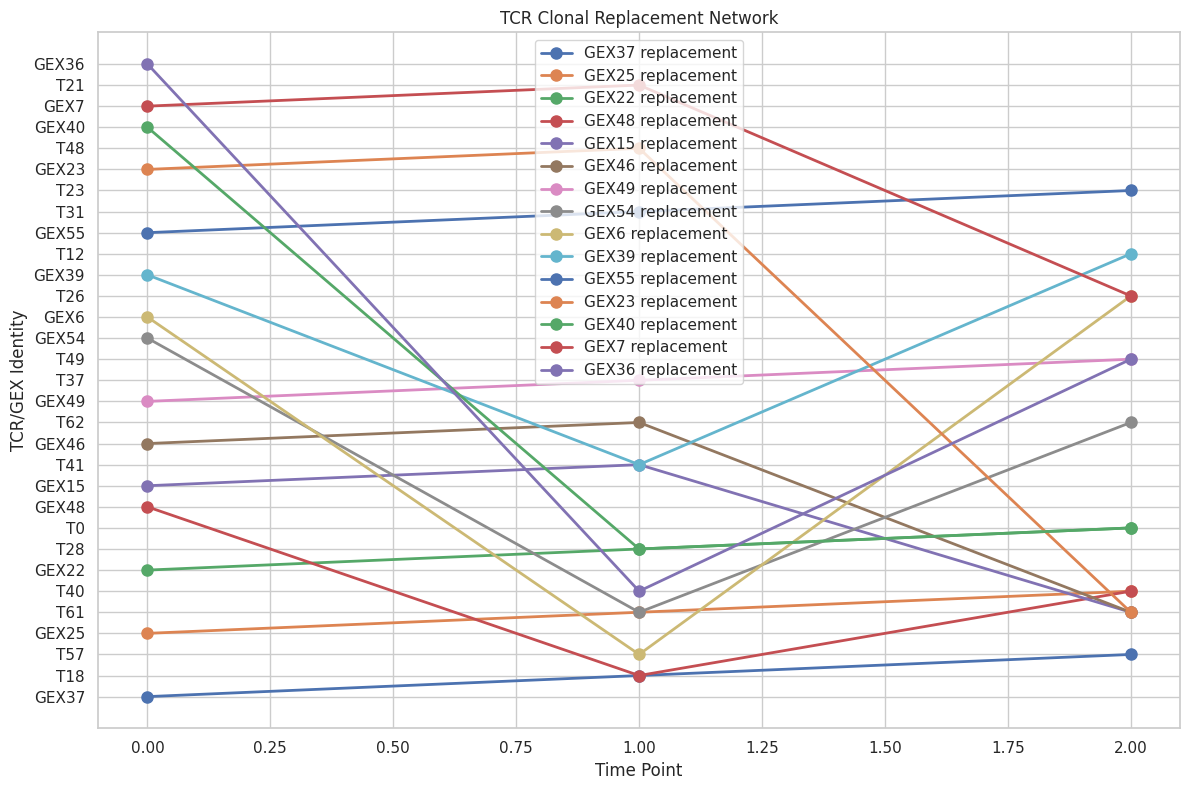

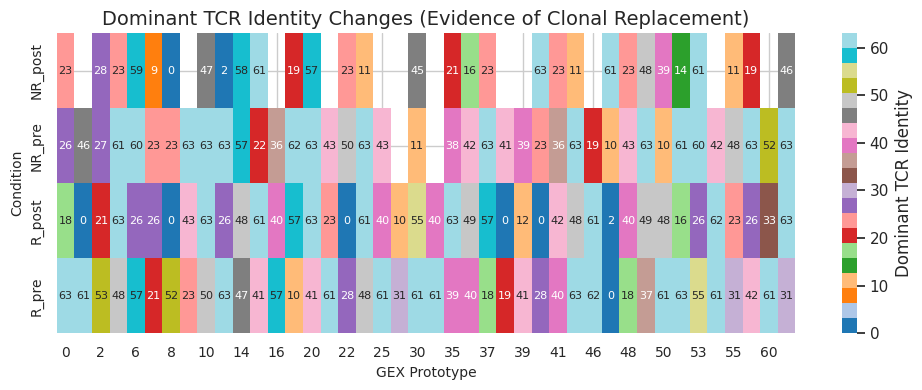

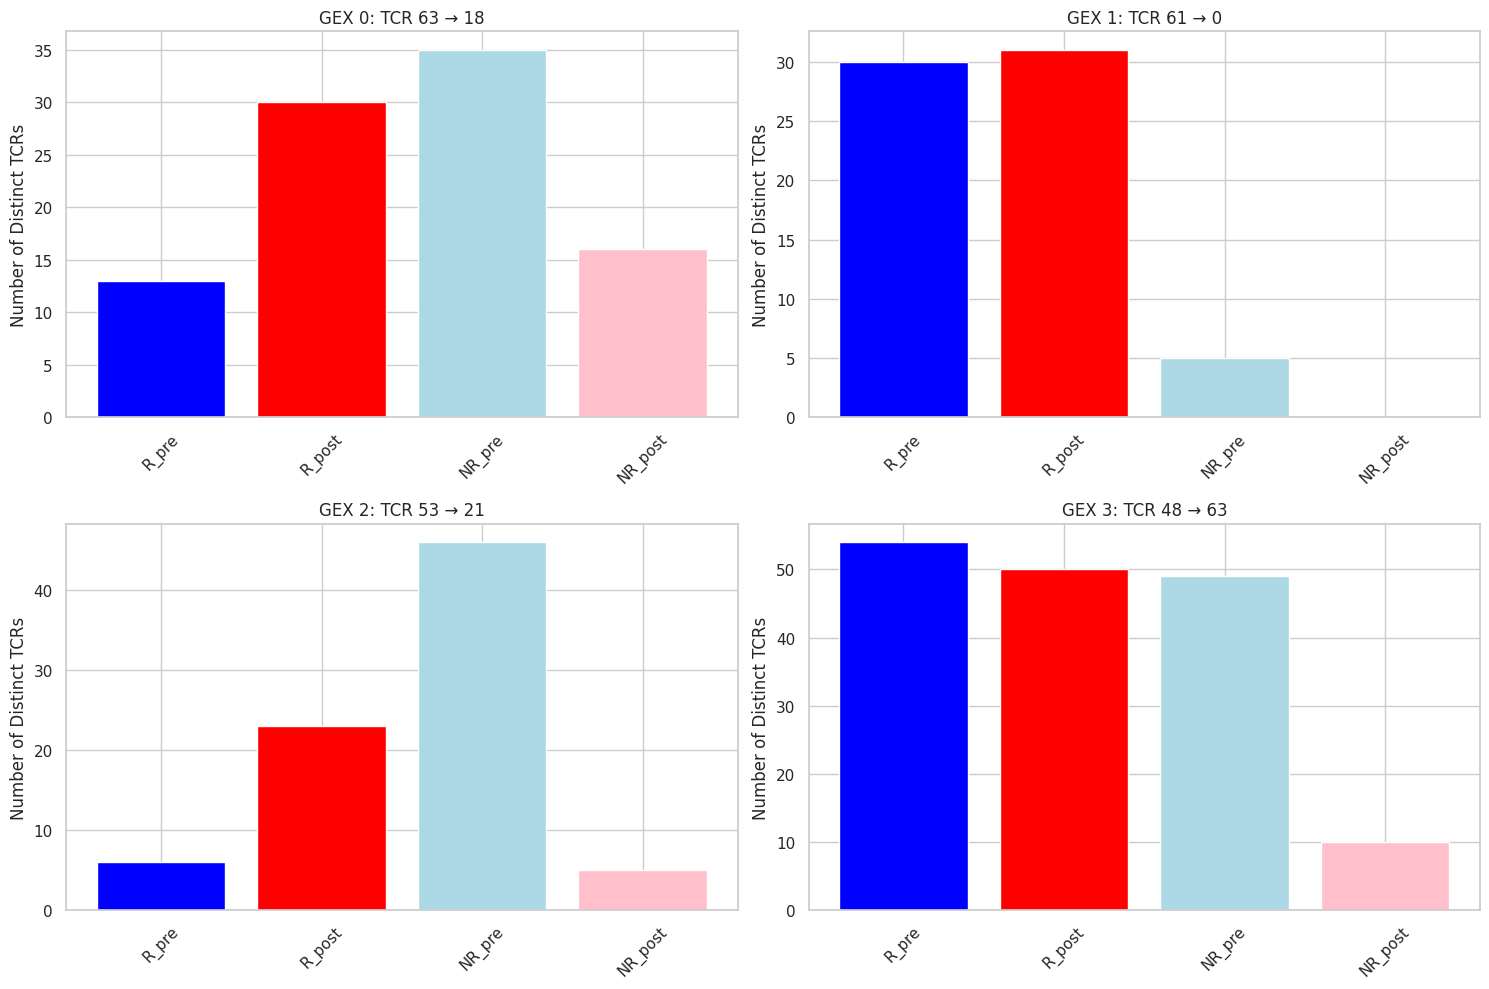

In [134]:
# 方法一：克隆替换网络图（最直观）
def plot_tcr_replacement_network(replacements_df, top_n=15):
    """绘制TCR替换网络图"""
    if len(replacements_df) == 0:
        print("没有发现显著的克隆替换")
        return
    
    # 选择替换强度最大的案例
    top_replacements = replacements_df.nlargest(top_n, 'replacement_strength')
    
    plt.figure(figsize=(12, 8))
    
    # 创建网络图
    for _, row in top_replacements.iterrows():
        gex_label = f"GEX{int(row['gex_idx'])}"
        pre_tcr = f"T{int(row['pre_dominant_tcr'])}"
        post_tcr = f"T{int(row['post_dominant_tcr'])}"
        
        # 绘制连线：GEX -> 治疗前TCR -> 治疗后TCR
        plt.plot([0, 1, 2], [gex_label, pre_tcr, post_tcr], 
                marker='o', linewidth=2, markersize=8, 
                label=f"{gex_label} replacement")
    
    plt.xlabel('Time Point')
    plt.ylabel('TCR/GEX Identity')
    plt.title('TCR Clonal Replacement Network')
    plt.legend()
    plt.tight_layout()
    plt.show()

# 方法二：克隆替换热图（显示具体TCR身份）
def plot_tcr_identity_heatmap(filtered_df, replacement_cases):
    """绘制显示具体TCR身份的热图（横纵轴反转）"""
    
    # 设置字体参数
    font_params = {
        'size': 10,               # 基础字体大小
        'weight': 'normal'        # 字重：normal, bold, light
    }
    
    # 应用字体设置
    plt.rc('font', **font_params)
    
    # 选择发生了替换的GEX原型
    gex_to_plot = replacement_cases['gex_idx'].tolist()
    plot_data = filtered_df[filtered_df['gex_idx'].isin(gex_to_plot)]
    
    # 修改这里：把条件放在行，GEX放在列
    pivot_tcr_id = plot_data.pivot(index='condition', columns='gex_idx', 
                                  values='dominant_tcr')
    
    # 调整图形尺寸以适应新的方向
    plt.figure(figsize=(10, 4))  # 根据GEX数量调整宽度
    
    # 绘制热图 - 关键修改：去掉横线
    sns.heatmap(pivot_tcr_id, 
                annot=True, 
                fmt='.0f', 
                cmap='tab20',
                cbar_kws={'label': 'Dominant TCR Identity'},
                linewidths=0,      # 关键修改：去掉所有网格线
                linecolor='white',
                annot_kws={'size': 8, 'weight': 'normal'},
                square=False)  # 注释文字字体
    
    plt.title('Dominant TCR Identity Changes (Evidence of Clonal Replacement)', 
              fontsize=14)  # 标题字体
    plt.xlabel('GEX Prototype', fontsize=10)  # X轴标签字体
    plt.ylabel('Condition', fontsize=10)     # Y轴标签字体
    
    # 设置坐标轴刻度字体 - 确保横坐标全部显示
    plt.xticks(rotation=0, fontsize=10)  # 横坐标不旋转，正常显示
    plt.yticks(fontsize=10)
    
    # 确保所有横坐标标签都显示
    plt.tight_layout()
    plt.show()

# 方法三：并排比较图
def plot_side_by_side_comparison(replacement_cases):
    """并排比较治疗前后的TCR组成"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.ravel()
    
    for i, (_, case) in enumerate(replacement_cases.head(4).iterrows()):
        gex_idx = case['gex_idx']
        
        # 获取这个GEX在四个条件下的数据
        gex_data = filtered_df[filtered_df['gex_idx'] == gex_idx]
        
        # 绘制TCR分布变化
        conditions = ['R_pre', 'R_post', 'NR_pre', 'NR_post']
        tcr_diversity = [gex_data[gex_data['condition'] == cond]['n_tcrs'].values[0] 
                        if len(gex_data[gex_data['condition'] == cond]) > 0 else 0
                        for cond in conditions]
        
        axes[i].bar(conditions, tcr_diversity, color=['blue', 'red', 'lightblue', 'pink'])
        axes[i].set_title(f'GEX {int(gex_idx)}: TCR {int(case["pre_dominant_tcr"])} → {int(case["post_dominant_tcr"])}')
        axes[i].set_ylabel('Number of Distinct TCRs')
        axes[i].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

# 运行可视化
if len(tcr_replacements) > 0:
    plot_tcr_replacement_network(tcr_replacements)
    plot_tcr_identity_heatmap(filtered_df, tcr_replacements)
    plot_side_by_side_comparison(tcr_replacements)
else:
    print("没有检测到显著的克隆替换事件")

In [96]:
# 检验克隆替换的显著性
from scipy import stats

def test_replacement_significance(replacement_cases):
    """检验克隆替换的统计显著性"""
    
    if len(replacement_cases) == 0:
        return
    
    # 检验主导TCR频率的变化
    pre_dominance = replacement_cases['pre_dominance_ratio']
    post_dominance = replacement_cases['post_dominance_ratio']
    
    t_stat, p_value = stats.ttest_rel(pre_dominance, post_dominance)
    
    print(f"克隆替换统计检验:")
    print(f"配对t检验: t = {t_stat:.3f}, p = {p_value:.4f}")
    print(f"治疗前主导TCR平均占比: {pre_dominance.mean():.3f}")
    print(f"治疗后主导TCR平均占比: {post_dominance.mean():.3f}")
    
    if p_value < 0.05:
        print("克隆替换效应显著！")
    else:
        print("克隆替换效应不显著")

test_replacement_significance(tcr_replacements)

克隆替换统计检验:
配对t检验: t = 2.719, p = 0.0096
治疗前主导TCR平均占比: 0.203
治疗后主导TCR平均占比: 0.133
克隆替换效应显著！


正在读取数据...
添加响应组信息...
找到PQ索引数据，形状: (14820, 2)

=== PQ索引基本信息 ===
索引矩阵形状: (14820, 2)
子空间数: 2
码本大小: 64
总细胞数: 14820
子空间 1 索引范围: 0 - 63
子空间 2 索引范围: 0 - 63


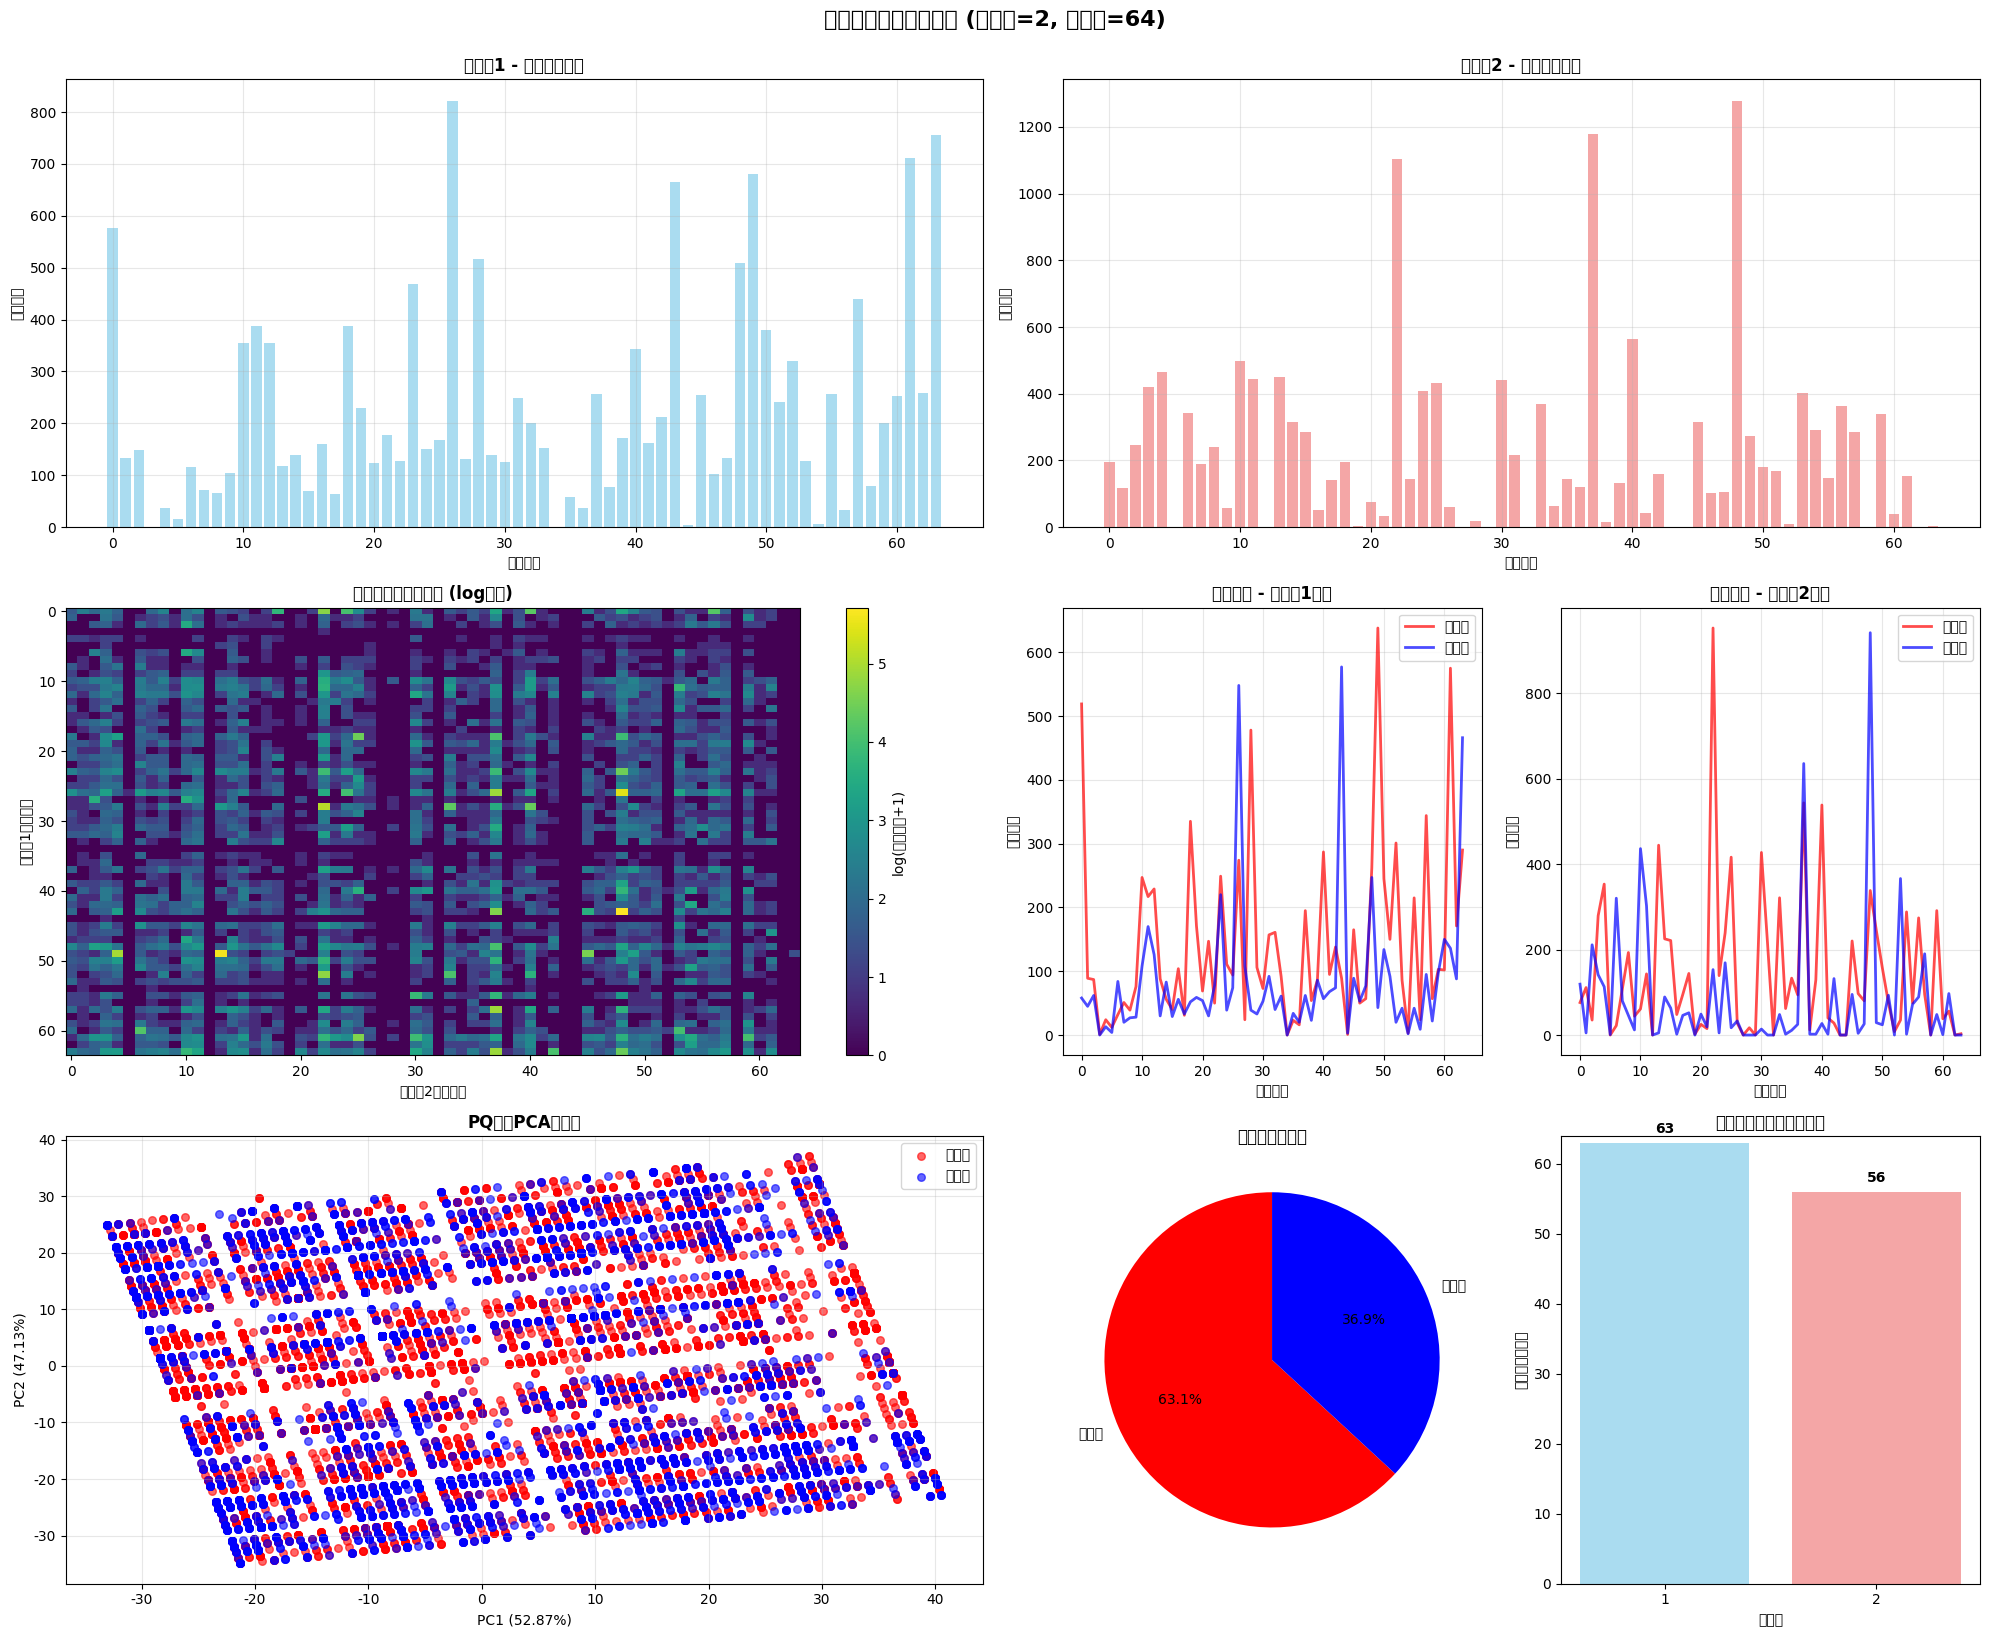


=== 统计分析结果 ===
各响应组细胞数量:
  有响应: 9355 个细胞
  无响应: 5465 个细胞

对 ['有响应', '无响应'] 进行统计检验:

子空间 1:
  卡方检验无法执行（可能数据不适合）
  各码本在两组的最大使用差异:
    码本 43: 差异 = 0.096

子空间 2:
  数据不适合进行卡方检验（期望频数过小）
  各码本在两组的最大使用差异:
    码本 48: 差异 = 0.136

=== 码本使用效率分析 ===
子空间 1:
  码本使用率: 98.4% (63/64)
  使用均衡度: 0.837 (越低越好)
子空间 2:
  码本使用率: 87.5% (56/64)
  使用均衡度: 1.006 (越低越好)

=== 基于PQ索引的聚类分析 ===
最佳聚类数: 4
轮廓系数: 0.454
与响应组的一致性(ARI): -0.000


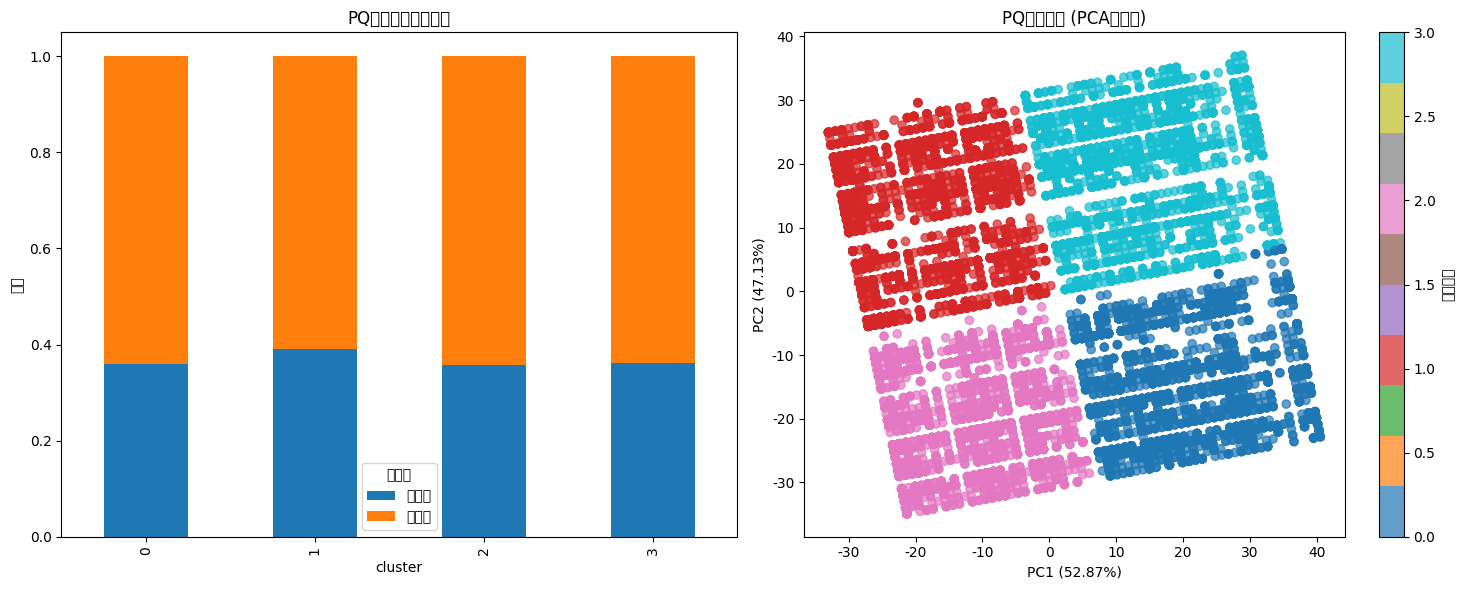


分析完成！


In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import scanpy as sc
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei', 'Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 读取数据
print("正在读取数据...")
obs_data = adata.obs

# 创建AnnData对象

# 添加响应组信息
print("添加响应组信息...")
adata.obs['response_group'] = '其他'
adata.obs.loc[adata.obs['patient'].isin(['su010', 'su011']), 'response_group'] = '有响应'
adata.obs.loc[adata.obs['patient'].isin(['su013', 'su014']), 'response_group'] = '无响应'

# 检查indices数据是否存在
if 'indices' not in adata.obsm:
    print("错误: 未找到adata.obsm['indices']数据")
    print("请确保乘积量化索引已正确存储在adata.obsm['indices']中")
else:
    pq_indices = adata.obsm['indices']
    print(f"找到PQ索引数据，形状: {pq_indices.shape}")
    
    # 确保索引数据是整数类型
    pq_indices = pq_indices.astype(int)
    
    # 分析PQ索引
    def analyze_pq_indices_comprehensive(adata, pq_indices):
        """
        综合分析乘积量化索引
        """
        n_subspaces = pq_indices.shape[1]
        codebook_size = 64
        
        print(f"\n=== PQ索引基本信息 ===")
        print(f"索引矩阵形状: {pq_indices.shape}")
        print(f"子空间数: {n_subspaces}")
        print(f"码本大小: {codebook_size}")
        print(f"总细胞数: {len(pq_indices)}")
        
        # 检查索引范围
        for i in range(n_subspaces):
            min_val = pq_indices[:, i].min()
            max_val = pq_indices[:, i].max()
            print(f"子空间 {i+1} 索引范围: {min_val} - {max_val}")
        
        # 创建综合可视化
        fig = plt.figure(figsize=(20, 16))
        
        # 1. 子空间码本使用分布
        ax1 = plt.subplot2grid((3, 4), (0, 0), colspan=2)
        subspace1_counts = np.bincount(pq_indices[:, 0], minlength=codebook_size)
        ax1.bar(range(codebook_size), subspace1_counts, alpha=0.7, color='skyblue')
        ax1.set_title('子空间1 - 码本使用分布', fontsize=12, fontweight='bold')
        ax1.set_xlabel('码本索引')
        ax1.set_ylabel('细胞数量')
        ax1.grid(True, alpha=0.3)
        
        ax2 = plt.subplot2grid((3, 4), (0, 2), colspan=2)
        subspace2_counts = np.bincount(pq_indices[:, 1], minlength=codebook_size)
        ax2.bar(range(codebook_size), subspace2_counts, alpha=0.7, color='lightcoral')
        ax2.set_title('子空间2 - 码本使用分布', fontsize=12, fontweight='bold')
        ax2.set_xlabel('码本索引')
        ax2.set_ylabel('细胞数量')
        ax2.grid(True, alpha=0.3)
        
        # 2. 联合分布热图
        ax3 = plt.subplot2grid((3, 4), (1, 0), colspan=2)
        joint_distribution = np.zeros((codebook_size, codebook_size))
        for i in range(len(pq_indices)):
            idx1, idx2 = pq_indices[i]
            joint_distribution[idx1, idx2] += 1
        
        # 使用对数变换使热图更易读
        joint_distribution_log = np.log1p(joint_distribution)
        im = ax3.imshow(joint_distribution_log, cmap='viridis', aspect='auto', 
                       interpolation='nearest')
        ax3.set_title('子空间联合分布热图 (log变换)', fontsize=12, fontweight='bold')
        ax3.set_xlabel('子空间2码本索引')
        ax3.set_ylabel('子空间1码本索引')
        plt.colorbar(im, ax=ax3, label='log(细胞数量+1)')
        
        # 3. 按响应组的子空间分布
        response_groups = ['有响应', '无响应']
        colors = {'有响应': 'red', '无响应': 'blue'}
        
        ax4 = plt.subplot2grid((3, 4), (1, 2))
        for group in response_groups:
            group_mask = adata.obs['response_group'] == group
            if group_mask.sum() > 0:  # 确保该组有细胞
                group_indices = pq_indices[group_mask]
                counts = np.bincount(group_indices[:, 0], minlength=codebook_size)
                ax4.plot(range(codebook_size), counts, 
                        label=group, color=colors[group], alpha=0.7, linewidth=2)
        
        ax4.set_title('按响应组 - 子空间1分布', fontsize=12, fontweight='bold')
        ax4.set_xlabel('码本索引')
        ax4.set_ylabel('细胞数量')
        ax4.legend()
        ax4.grid(True, alpha=0.3)
        
        ax5 = plt.subplot2grid((3, 4), (1, 3))
        for group in response_groups:
            group_mask = adata.obs['response_group'] == group
            if group_mask.sum() > 0:  # 确保该组有细胞
                group_indices = pq_indices[group_mask]
                counts = np.bincount(group_indices[:, 1], minlength=codebook_size)
                ax5.plot(range(codebook_size), counts, 
                        label=group, color=colors[group], alpha=0.7, linewidth=2)
        
        ax5.set_title('按响应组 - 子空间2分布', fontsize=12, fontweight='bold')
        ax5.set_xlabel('码本索引')
        ax5.set_ylabel('细胞数量')
        ax5.legend()
        ax5.grid(True, alpha=0.3)
        
        # 4. PQ索引的PCA可视化
        ax6 = plt.subplot2grid((3, 4), (2, 0), colspan=2)
        pca = PCA(n_components=2)
        pq_pca = pca.fit_transform(pq_indices)
        
        # 为每个响应组绘制散点
        for group in response_groups:
            group_mask = adata.obs['response_group'] == group
            if group_mask.sum() > 0:
                ax6.scatter(pq_pca[group_mask, 0], pq_pca[group_mask, 1], 
                           c=colors[group], label=group, alpha=0.6, s=30)
        
        ax6.set_title('PQ索引PCA可视化', fontsize=12, fontweight='bold')
        ax6.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
        ax6.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
        ax6.legend()
        ax6.grid(True, alpha=0.3)
        
        # 5. 响应组细胞数量统计
        ax7 = plt.subplot2grid((3, 4), (2, 2))
        response_counts = adata.obs['response_group'].value_counts()
        colors_pie = [colors.get(group, 'gray') for group in response_counts.index]
        wedges, texts, autotexts = ax7.pie(response_counts.values, labels=response_counts.index, 
                                          autopct='%1.1f%%', colors=colors_pie, startangle=90)
        ax7.set_title('响应组细胞分布', fontsize=12, fontweight='bold')
        
        # 6. 码本使用统计
        ax8 = plt.subplot2grid((3, 4), (2, 3))
        total_used_codes = []
        for i in range(n_subspaces):
            used_codes = (np.bincount(pq_indices[:, i], minlength=codebook_size) > 0).sum()
            total_used_codes.append(used_codes)
        
        ax8.bar(range(1, n_subspaces+1), total_used_codes, 
                color=['skyblue', 'lightcoral'], alpha=0.7)
        ax8.set_title('各子空间实际使用码本数', fontsize=12, fontweight='bold')
        ax8.set_xlabel('子空间')
        ax8.set_ylabel('使用的码本数量')
        ax8.set_xticks(range(1, n_subspaces+1))
        ax8.set_ylim(0, codebook_size)
        
        # 在柱状图上添加数值标签
        for i, v in enumerate(total_used_codes):
            ax8.text(i+1, v + 1, str(v), ha='center', va='bottom', fontweight='bold')
        
        plt.tight_layout()
        plt.suptitle('乘积量化索引综合分析 (子空间=2, 码本数=64)', fontsize=16, fontweight='bold', y=1.02)
        plt.show()
        
        # 统计分析
        print("\n=== 统计分析结果 ===")
        
        # 检查每个响应组的细胞数量
        response_counts = adata.obs['response_group'].value_counts()
        print("各响应组细胞数量:")
        for group, count in response_counts.items():
            print(f"  {group}: {count} 个细胞")
        
        # 只对有响应和无响应两组进行统计检验
        focus_groups = ['有响应', '无响应']
        valid_groups = [group for group in focus_groups if group in response_counts.index and response_counts[group] > 0]
        
        if len(valid_groups) >= 2:
            print(f"\n对 {valid_groups} 进行统计检验:")
            
            for subspace in range(n_subspaces):
                print(f"\n子空间 {subspace + 1}:")
                
                # 创建列联表
                contingency_data = []
                for group in valid_groups:
                    group_mask = adata.obs['response_group'] == group
                    group_counts = np.bincount(pq_indices[group_mask, subspace], 
                                             minlength=codebook_size)
                    contingency_data.append(group_counts)
                
                contingency_table = np.array(contingency_data)
                
                # 检查数据是否适合卡方检验
                if contingency_table.sum() > 0 and (contingency_table >= 5).sum() / contingency_table.size > 0.8:
                    try:
                        chi2, p_value, dof, expected = chi2_contingency(contingency_table)
                        print(f"  卡方检验: χ² = {chi2:.2f}, p-value = {p_value:.4f}")
                        
                        if p_value < 0.05:
                            print("  ✓ 响应组间在码本使用上有显著差异 (p < 0.05)")
                        else:
                            print("  ✗ 响应组间在码本使用上无显著差异")
                    except:
                        print("  卡方检验无法执行（可能数据不适合）")
                else:
                    print("  数据不适合进行卡方检验（期望频数过小）")
                
                # 计算每个码本的使用差异
                print(f"  各码本在两组的最大使用差异:")
                max_diff = 0
                max_diff_code = -1
                for code in range(codebook_size):
                    group_usage = []
                    for group in valid_groups:
                        group_mask = adata.obs['response_group'] == group
                        usage = (pq_indices[group_mask, subspace] == code).sum() / group_mask.sum()
                        group_usage.append(usage)
                    
                    diff = abs(group_usage[0] - group_usage[1]) if len(group_usage) == 2 else 0
                    if diff > max_diff:
                        max_diff = diff
                        max_diff_code = code
                
                if max_diff_code >= 0:
                    print(f"    码本 {max_diff_code}: 差异 = {max_diff:.3f}")
        
        # 码本使用效率分析
        print(f"\n=== 码本使用效率分析 ===")
        for i in range(n_subspaces):
            code_usage = np.bincount(pq_indices[:, i], minlength=codebook_size)
            usage_rate = (code_usage > 0).sum() / codebook_size
            usage_balance = np.std(code_usage[code_usage > 0]) / np.mean(code_usage[code_usage > 0]) if (code_usage > 0).sum() > 0 else 0
            
            print(f"子空间 {i+1}:")
            print(f"  码本使用率: {usage_rate:.1%} ({ (code_usage > 0).sum() }/{codebook_size})")
            print(f"  使用均衡度: {usage_balance:.3f} (越低越好)")
        
        return pq_indices
    
    # 执行分析
    pq_indices = analyze_pq_indices_comprehensive(adata, pq_indices)
    
    # 额外的聚类分析
    def cluster_analysis_based_on_pq(adata, pq_indices):
        """基于PQ索引进行聚类分析"""
        print("\n=== 基于PQ索引的聚类分析 ===")
        
        from sklearn.cluster import KMeans
        from sklearn.metrics import silhouette_score, adjusted_rand_score
        
        # 只使用有响应和无响应的细胞
        focus_mask = adata.obs['response_group'].isin(['有响应', '无响应'])
        focus_indices = pq_indices[focus_mask]
        focus_response = adata.obs['response_group'][focus_mask]
        
        if len(focus_indices) < 10:
            print("有响应和无响应的细胞数量不足，跳过聚类分析")
            return
        
        # 寻找最佳聚类数
        silhouette_scores = []
        possible_k = range(2, min(8, len(focus_indices)//10 + 2))
        
        for k in possible_k:
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            cluster_labels = kmeans.fit_predict(focus_indices)
            if len(np.unique(cluster_labels)) > 1:
                score = silhouette_score(focus_indices, cluster_labels)
                silhouette_scores.append(score)
            else:
                silhouette_scores.append(-1)
        
        if silhouette_scores:
            best_k = possible_k[np.argmax(silhouette_scores)]
            best_score = max(silhouette_scores)
            
            # 使用最佳聚类数
            kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
            cluster_labels = kmeans.fit_predict(focus_indices)
            
            # 计算聚类与响应组的一致性
            ari = adjusted_rand_score(focus_response, cluster_labels)
            
            print(f"最佳聚类数: {best_k}")
            print(f"轮廓系数: {best_score:.3f}")
            print(f"与响应组的一致性(ARI): {ari:.3f}")
            
            # 可视化聚类结果
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
            
            # 聚类与响应组的关系
            cluster_df = pd.DataFrame({
                'cluster': cluster_labels,
                'response': focus_response
            })
            cross_tab = pd.crosstab(cluster_df['cluster'], cluster_df['response'], normalize='index')
            cross_tab.plot(kind='bar', ax=ax1, stacked=True)
            ax1.set_title('PQ聚类与响应组分布')
            ax1.set_ylabel('比例')
            ax1.legend(title='响应组')
            
            # 聚类中心可视化
            pca = PCA(n_components=2)
            focus_pca = pca.fit_transform(focus_indices)
            
            scatter = ax2.scatter(focus_pca[:, 0], focus_pca[:, 1], 
                                 c=cluster_labels, cmap='tab10', alpha=0.7)
            ax2.set_title('PQ聚类结果 (PCA可视化)')
            ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
            ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
            plt.colorbar(scatter, ax=ax2, label='聚类标签')
            
            plt.tight_layout()
            plt.show()
        else:
            print("无法进行聚类分析")
    
    # 执行聚类分析
    cluster_analysis_based_on_pq(adata, pq_indices)
    
    print("\n分析完成！")
